In [2]:
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm  # Notebook-friendly progress bar

# --- Configuration ---
metadata_path = "datasets2/stations_info.csv"   # Path to the metadata file
data_dir = "datasets2/datasets"         # Directory containing all measurement CSV files

# Define the expected columns for each measurement file (adjust as needed)
expected_columns = [
    "From Date", "To Date", "PM2.5", "PM10", "NO", "NO2", "NOx",
    "NH3", "SO2", "CO", "Ozone", "Benzene", "Toluene", "Temp", "RH"
]

# Settings for time alignment: expecting ~1 hour difference ± 5 minutes tolerance
expected_diff = pd.Timedelta(hours=1)
tolerance = pd.Timedelta(minutes=5)

# Load metadata to acquire the list of filenames
stations_info = pd.read_csv(metadata_path)

# --- Optional: Filter for Southern Stations ---
# Uncomment these lines to restrict analysis to southern states:
# southern_states = ["Andhra Pradesh", "Telangana", "Karnataka", "Kerala", "Tamil Nadu"]
# stations_info = stations_info[stations_info["state"].isin(southern_states)]
# print(f"Total southern stations: {len(stations_info)}")

# --- Define a Function to Process Each File ---
def process_file(file_name):
    # Ensure the file name has a '.csv' extension
    if not os.path.splitext(file_name)[1]:
        file_name += ".csv"
    
    file_path = os.path.join(data_dir, file_name)
    try:
        # Load the CSV file with "From Date" parsed as datetime.
        df = pd.read_csv(file_path, parse_dates=["From Date"])
    except Exception as e:
        return {
            "file_name": file_name,
            "error": f"Error loading file: {e}"
        }

    # --- Check 1: Column Consistency ---
    missing_cols = [col for col in expected_columns if col not in df.columns]

    # --- Check 2: Time Alignment ---
    df.sort_values("From Date", inplace=True)
    median_diff = None
    time_alignment_ok = None
    if len(df) > 1:
        time_diffs = df["From Date"].diff().dropna()
        median_diff = time_diffs.median()
        time_alignment_ok = abs(median_diff - expected_diff) < tolerance

    # --- Check 3: Missing Values ---
    missing_info = {}
    for col in expected_columns:
        if col in df.columns:
            missing_fraction = df[col].isna().mean()
            missing_info[col] = missing_fraction

    return {
        "file_name": file_name,
        "num_rows": len(df),
        "missing_columns": missing_cols,
        "median_time_diff": median_diff,
        "time_alignment_ok": time_alignment_ok,
        "missing_info": missing_info
    }

# --- Process All Files in Parallel ---
results = []
max_workers = 8  # Adjust based on your system's performance

# Get the list of all filenames from the metadata
file_names = stations_info["file_name"].tolist()

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(process_file, f_name): f_name for f_name in file_names}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        results.append(future.result())

# --- Reporting the Results ---
print("\nSummary of Dataset Checks:")
for res in results:
    print(f"\nFile: {res.get('file_name')}")
    if "error" in res:
        print(f"  ERROR: {res['error']}")
        print("-" * 40)
        continue

    print(f"  Number of Rows: {res['num_rows']}")
    if res["missing_columns"]:
        print(f"  Missing Expected Columns: {res['missing_columns']}")
    else:
        print("  All expected columns are present.")
    
    if res["median_time_diff"] is not None:
        print(f"  Median Time Difference: {res['median_time_diff']}")
        print("  Time Alignment Check:", "OK" if res["time_alignment_ok"] else "Not OK")
    else:
        print("  Not enough data to check time differences.")
    
    print("  Missing Value Fraction per Expected Column:")
    for col, frac in res["missing_info"].items():
        print(f"    - {col}: {frac:.2%}")
    print("-" * 40)


Processing files:   0%|          | 0/453 [00:00<?, ?it/s]


Summary of Dataset Checks:

File: AP007.csv
  Number of Rows: 3127
  Missing Expected Columns: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'Temp', 'RH']
  Median Time Difference: 0 days 01:00:00
  Time Alignment Check: OK
  Missing Value Fraction per Expected Column:
    - From Date: 0.00%
    - To Date: 0.00%
----------------------------------------

File: AP008.csv
  Number of Rows: 3280
  Missing Expected Columns: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'Temp', 'RH']
  Median Time Difference: 0 days 01:00:00
  Time Alignment Check: OK
  Missing Value Fraction per Expected Column:
    - From Date: 0.00%
    - To Date: 0.00%
----------------------------------------

File: AP006.csv
  Number of Rows: 5432
  Missing Expected Columns: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'Temp', 'RH']
  Median Time Difference: 0 days 01:00:00
  Time Alignment 

In [3]:
import pandas as pd
import os

# Set the data directory and a file name to inspect
data_dir = "datasets2/datasets"
file_name = "AP008.csv"  # or "AP008" (the code below will add the '.csv' if missing)

# Ensure the file name has a '.csv' extension
if not os.path.splitext(file_name)[1]:
    file_name += ".csv"

file_path = os.path.join(data_dir, file_name)

# Read only the header (or a few rows) to inspect the schema
df_inspect = pd.read_csv(file_path, nrows=5)
print("Columns in", file_name, ":\n", list(df_inspect.columns))
print("\nFirst few rows:")
print(df_inspect.head())


Columns in AP008.csv :
 ['From Date', 'To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'RF (mm)', 'AT (degree C)']

First few rows:
             From Date              To Date  PM2.5 (ug/m3)  PM10 (ug/m3)  \
0  2022-11-15 08:00:00  2022-11-15 09:00:00          15.05         18.82   
1  2022-11-15 09:00:00  2022-11-15 10:00:00          12.18         15.23   
2  2022-11-15 10:00:00  2022-11-15 11:00:00          23.05         28.80   
3  2022-11-15 11:00:00  2022-11-15 12:00:00          63.29         79.12   
4  2022-11-15 12:00:00  2022-11-15 13:00:00          93.06        116.33   

   NO (ug/m3)  NO2 (ug/m3)  NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
0         3.0        63.86      44.35         9.28     

In [4]:
import pandas as pd
import os

# Define a mapping of the canonical (expected) column names 
# and all acceptable variations that you expect to see.
expected_mapping = {
    "From Date": ["From Date"],
    "To Date": ["To Date"],
    "PM2.5": ["PM2.5", "PM2.5 (ug/m3)"],
    "PM10": ["PM10", "PM10 (ug/m3)"],
    "NO": ["NO", "NO (ug/m3)"],
    "NO2": ["NO2", "NO2 (ug/m3)"],
    "NOx": ["NOx", "NOx (ppb)"],
    "NH3": ["NH3", "NH3 (ug/m3)"],
    "SO2": ["SO2", "SO2 (ug/m3)"],
    "CO": ["CO", "CO (mg/m3)"],
    "Ozone": ["Ozone", "Ozone (ug/m3)"],
    "Benzene": ["Benzene", "Benzene (ug/m3)"],
    "Toluene": ["Toluene", "Toluene (ug/m3)"],
    "Temp": ["Temp", "AT (degree C)"],
    "RH": ["RH", "RH (%)"]
}

def check_file_schema(file_name, data_dir="datasets2/datasets"):
    """
    This function reads the header (first row) from a given file,
    then checks for each canonical expected column whether any acceptable
    variation exists.
    """
    # Ensure the filename ends with '.csv'
    if not os.path.splitext(file_name)[1]:
        file_name_with_ext = file_name + ".csv"
    else:
        file_name_with_ext = file_name

    file_path = os.path.join(data_dir, file_name_with_ext)
    
    try:
        # Read header only (nrows=0) to get column names without loading full file
        df = pd.read_csv(file_path, nrows=0)
        actual_columns = list(df.columns)
    except Exception as e:
        return file_name_with_ext, f"Error: {e}", {}
    
    # For each expected canonical column, record whether any acceptable alternative was found.
    found_mapping = {}
    for key, alternatives in expected_mapping.items():
        found_mapping[key] = any(col in actual_columns for col in alternatives)
    
    return file_name_with_ext, actual_columns, found_mapping

# Load metadata to obtain the list of files
stations_info = pd.read_csv("datasets2/stations_info.csv")
all_file_names = stations_info["file_name"].tolist()

# For demonstration, let's inspect the first 5 files:
for f in all_file_names[:5]:
    f_name, schema, mapping_check = check_file_schema(f)
    print("File:", f_name)
    print("Columns:", schema)
    print("Expected Columns Check:")
    for key, found in mapping_check.items():
        print(f"  {key}: {'Found' if found else 'NOT found'}")
    print("-" * 50)


File: AP001.csv
Columns: ['From Date', 'To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'Xylene (ug/m3)', 'RF (mm)', 'AT (degree C)']
Expected Columns Check:
  From Date: Found
  To Date: Found
  PM2.5: Found
  PM10: Found
  NO: Found
  NO2: Found
  NOx: Found
  NH3: Found
  SO2: Found
  CO: Found
  Ozone: Found
  Benzene: Found
  Toluene: Found
  Temp: Found
  RH: Found
--------------------------------------------------
File: AP002.csv
Columns: ['From Date', 'To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'SR (W/mt2)', 'BP (mmHg)

In [5]:
import pandas as pd
import os

# Using the previously defined expected_mapping from Step 2
expected_mapping = {
    "From Date": ["From Date"],
    "To Date": ["To Date"],
    "PM2.5": ["PM2.5", "PM2.5 (ug/m3)"],
    "PM10": ["PM10", "PM10 (ug/m3)"],
    "NO": ["NO", "NO (ug/m3)"],
    "NO2": ["NO2", "NO2 (ug/m3)"],
    "NOx": ["NOx", "NOx (ppb)"],
    "NH3": ["NH3", "NH3 (ug/m3)"],
    "SO2": ["SO2", "SO2 (ug/m3)"],
    "CO": ["CO", "CO (mg/m3)"],
    "Ozone": ["Ozone", "Ozone (ug/m3)"],
    "Benzene": ["Benzene", "Benzene (ug/m3)"],
    "Toluene": ["Toluene", "Toluene (ug/m3)"],
    "Temp": ["Temp", "AT (degree C)", "Temp (degree C)"],
    "RH": ["RH", "RH (%)"]
}

def check_file_schema_mapping(file_name, data_dir="datasets2/datasets"):
    """
    Check the file's columns and evaluate if each canonical key is found based
    on our mapping of expected alternatives.
    Returns:
      - file_name (with .csv if necessary)
      - actual columns list
      - count of keys found
      - details mapping of key -> True/False whether found
    """
    if not os.path.splitext(file_name)[1]:
        file_name = file_name + ".csv"
    file_path = os.path.join(data_dir, file_name)
    try:
        df = pd.read_csv(file_path, nrows=0)
        actual_cols = list(df.columns)
    except Exception as e:
        return file_name, [], 0, None, f"Error: {e}"
    
    found_map = {}
    count_found = 0
    for key, alternatives in expected_mapping.items():
        found = any(col in actual_cols for col in alternatives)
        found_map[key] = found
        if found:
            count_found += 1
    return file_name, actual_cols, count_found, found_map, None

# Load metadata of all files
stations_info = pd.read_csv("datasets2/stations_info.csv")
all_file_names = stations_info["file_name"].tolist()

# Define a threshold for how many keys must be present
# For instance, if we have 15 expected keys, you might require at least 12.
total_expected = len(expected_mapping)
min_required = int(total_expected * 0.8)  # e.g., 80% of expected keys must be present

compatible_files = []
incompatible_files = []

for f in all_file_names:
    fname, actual_cols, count_found, mapping, err = check_file_schema_mapping(f)
    if err:
        print(f"Error checking {fname}: {err}")
        continue
    if count_found >= min_required:
        compatible_files.append((fname, actual_cols, count_found, mapping))
    else:
        incompatible_files.append((fname, actual_cols, count_found, mapping))

print("Summary of Schema Check for All Files:")
print(f"Total files: {len(all_file_names)}")
print(f"Compatible files (>= {min_required} keys found): {len(compatible_files)}")
print(f"Incompatible files (< {min_required} keys found): {len(incompatible_files)}")

print("\nIncompatible Files:")
for fname, cols, count_found, mapping in incompatible_files:
    print(f"  {fname}: {count_found} out of {total_expected} keys found. Columns found: {cols}")

print("\nCompatible Files:")
for fname, cols, count_found, mapping in compatible_files:
    print(f"  {fname}: {count_found} out of {total_expected} keys found.")


Summary of Schema Check for All Files:
Total files: 453
Compatible files (>= 12 keys found): 426
Incompatible files (< 12 keys found): 27

Incompatible Files:
  CG001.csv: 11 out of 15 keys found. Columns found: ['From Date', 'To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'AT (degree C)', 'RF (mm)']
  GJ006.csv: 9 out of 15 keys found. Columns found: ['From Date', 'To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'SO2 (ug/m3)', 'CO (mg/m3)']
  GJ017.csv: 11 out of 15 keys found. Columns found: ['From Date', 'To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'AT (degree C)', 'RF (mm)']
  HR005.csv: 7 out of 15 keys found. Columns found: ['From Date', 'To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'N

In [6]:
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

# We'll reuse the expected_mapping defined in Step 2:
expected_mapping = {
    "From Date": ["From Date"],
    "To Date": ["To Date"],
    "PM2.5": ["PM2.5", "PM2.5 (ug/m3)"],
    "PM10": ["PM10", "PM10 (ug/m3)"],
    "NO": ["NO", "NO (ug/m3)"],
    "NO2": ["NO2", "NO2 (ug/m3)"],
    "NOx": ["NOx", "NOx (ppb)"],
    "NH3": ["NH3", "NH3 (ug/m3)"],
    "SO2": ["SO2", "SO2 (ug/m3)"],
    "CO": ["CO", "CO (mg/m3)"],
    "Ozone": ["Ozone", "Ozone (ug/m3)"],
    "Benzene": ["Benzene", "Benzene (ug/m3)"],
    "Toluene": ["Toluene", "Toluene (ug/m3)"],
    "Temp": ["Temp", "AT (degree C)", "Temp (degree C)"],
    "RH": ["RH", "RH (%)"]
}

# Define the data directory where the CSV files are located
data_dir = "datasets2/datasets"

def process_compatible_file(file_name, data_dir=data_dir):
    """
    Process a file from the compatible files list:
      - Loads the file (parsing "From Date" as datetime).
      - Sorts the DataFrame by "From Date".
      - Checks the median time difference between consecutive timestamps (should be ~1 hour ± 5 minutes).
      - Computes the fraction of missing values for each expected key (using our expected_mapping).
    """
    # Ensure file name ends with '.csv'
    if not os.path.splitext(file_name)[1]:
        file_name = file_name + ".csv"
        
    file_path = os.path.join(data_dir, file_name)
    
    try:
        # Load the file and parse the "From Date" column as datetime
        df = pd.read_csv(file_path, parse_dates=["From Date"])
    except Exception as e:
        return {
            "file_name": file_name,
            "error": f"Error loading file: {e}"
        }
    
    # Sort the DataFrame by "From Date" to ensure proper time ordering
    df.sort_values("From Date", inplace=True)
    
    # Check time alignment (median difference)
    median_diff = None
    time_alignment_ok = None
    if len(df) > 1:
        time_diffs = df["From Date"].diff().dropna()
        median_diff = time_diffs.median()
        expected_diff = pd.Timedelta(hours=1)
        tolerance = pd.Timedelta(minutes=5)
        time_alignment_ok = abs(median_diff - expected_diff) < tolerance
    
    # Compute missing value fraction for each expected key:
    # We'll look for the first acceptable column for each canonical key.
    missing_info = {}
    for key, alternatives in expected_mapping.items():
        found_col = None
        for alt in alternatives:
            if alt in df.columns:
                found_col = alt
                break
        if found_col is not None:
            missing_info[key] = df[found_col].isna().mean()
        else:
            missing_info[key] = None  # Could indicate the key wasn't found (should not occur here)
    
    return {
        "file_name": file_name,
        "nrows": df.shape[0],
        "median_diff": median_diff,
        "time_alignment": time_alignment_ok,
        "missing_info": missing_info
    }

# Assuming we already obtained a list of compatible files from Step 3
# Here, `compatible_files` is a list of tuples: (file_name, actual_columns, count_found, mapping)
# We'll extract just the file names.
compatible_file_names = [fname for fname, _, _, _ in compatible_files]

# Process the compatible files in parallel using ThreadPoolExecutor
results = []
max_workers = 8  # Adjust based on your system's capacity

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(process_compatible_file, f_name): f_name for f_name in compatible_file_names}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing compatible files"):
        results.append(future.result())

# Print a summary of the results
print("Summary of Data Quality Checks for Compatible Files:")
for res in results:
    print(f"\nFile: {res.get('file_name')}")
    if "error" in res:
        print(f"  ERROR: {res['error']}")
        print("-" * 40)
        continue
    print(f"  Number of rows: {res['nrows']}")
    if res["median_diff"] is not None:
        print(f"  Median Time Difference: {res['median_diff']}  ->  Time Alignment: {'OK' if res['time_alignment'] else 'Not OK'}")
    else:
        print("  Not enough data to check time differences.")
    print("  Missing Value Fraction per Expected Key:")
    for key, frac in res["missing_info"].items():
        if frac is not None:
            print(f"    {key}: {frac:.2%}")
        else:
            print(f"    {key}: NOT FOUND")
    print("-" * 40)


Processing compatible files:   0%|          | 0/426 [00:00<?, ?it/s]

Summary of Data Quality Checks for Compatible Files:

File: AP007.csv
  Number of rows: 3127
  Median Time Difference: 0 days 01:00:00  ->  Time Alignment: OK
  Missing Value Fraction per Expected Key:
    From Date: 0.00%
    To Date: 0.00%
    PM2.5: 13.11%
    PM10: 13.18%
    NO: 3.45%
    NO2: 3.26%
    NOx: 2.85%
    NH3: 2.85%
    SO2: 5.53%
    CO: 9.37%
    Ozone: 3.04%
    Benzene: 2.17%
    Toluene: 2.17%
    Temp: 2.17%
    RH: 2.17%
----------------------------------------

File: AP008.csv
  Number of rows: 3280
  Median Time Difference: 0 days 01:00:00  ->  Time Alignment: OK
  Missing Value Fraction per Expected Key:
    From Date: 0.00%
    To Date: 0.00%
    PM2.5: 9.18%
    PM10: 16.43%
    NO: 13.23%
    NO2: 5.73%
    NOx: 5.70%
    NH3: 11.34%
    SO2: 4.45%
    CO: 5.00%
    Ozone: 4.82%
    Benzene: 8.08%
    Toluene: 8.08%
    Temp: 4.42%
    RH: 4.42%
----------------------------------------

File: AP006.csv
  Number of rows: 5432
  Median Time Difference: 0 da

In [7]:
missing_threshold = 0.40

good_files = []
excluded_files = []

for res in results:
    if "error" in res:
        continue
    valid_fractions = [frac for frac in res["missing_info"].values() if frac is not None]
    avg_missing = sum(valid_fractions) / len(valid_fractions) if valid_fractions else 1.0
    if avg_missing <= missing_threshold:
        good_files.append((res["file_name"], avg_missing))
    else:
        excluded_files.append((res["file_name"], avg_missing))

print("Files to be used (average missing fraction <= 40%):")
for fname, avg in good_files:
    print(f"{fname}: {avg:.2%}")

print("\nFiles to be excluded (average missing fraction > 40%):")
for fname, avg in excluded_files:
    print(f"{fname}: {avg:.2%}")


Files to be used (average missing fraction <= 40%):
AP007.csv: 4.36%
AP008.csv: 6.73%
AP006.csv: 12.16%
AP009.csv: 19.82%
AP010.csv: 3.16%
AS002.csv: 25.09%
AS003.csv: 22.11%
AP003.csv: 7.75%
AS006.csv: 8.25%
AS005.csv: 6.23%
AS004.csv: 7.45%
AP001.csv: 6.39%
AP004.csv: 3.31%
AS001.csv: 9.41%
AP005.csv: 7.85%
AS007.csv: 13.43%
AS009.csv: 5.78%
AS008.csv: 9.42%
BR004.csv: 4.59%
BR008.csv: 9.44%
BR005.csv: 2.28%
BR007.csv: 4.19%
BR006.csv: 4.92%
BR003.csv: 20.52%
BR002.csv: 20.11%
BR001.csv: 35.74%
BR012.csv: 30.04%
BR013.csv: 29.75%
BR014.csv: 22.30%
BR011.csv: 4.52%
BR010.csv: 6.85%
BR009.csv: 5.30%
BR015.csv: 26.49%
BR016.csv: 31.49%
BR017.csv: 24.37%
BR021.csv: 11.41%
BR022.csv: 28.87%
BR020.csv: 11.33%
BR018.csv: 26.13%
BR019.csv: 24.90%
BR023.csv: 5.30%
BR024.csv: 27.71%
BR025.csv: 10.01%
BR028.csv: 25.03%
BR027.csv: 36.36%
BR026.csv: 5.60%
BR029.csv: 9.80%
BR030.csv: 18.32%
BR031.csv: 18.30%
CG004.csv: 39.88%
CG005.csv: 36.32%
BR032.csv: 11.20%
BR033.csv: 10.04%
CG006.csv: 36.41%



Merged data saved incrementally to merged_data.csv

Summary statistics on a 10% sample computed using Dask:
                 From Date              To Date          PM2.5           PM10  \
count               268447               158069  779806.000000  771546.000000   
min    2010-01-01 22:00:00  2017-07-01 12:00:00       0.000000       0.000000   
25%    2020-11-10 21:00:00  2021-07-21 12:30:00      10.570000       7.110000   
50%    2022-02-16 05:00:00  2022-06-15 08:30:00      31.380000      28.305000   
75%    2023-02-03 16:15:00  2023-02-03 17:15:00     149.500000     198.890000   
max    2023-04-01 00:00:00  2023-04-01 00:00:00     999.990000    1094.800000   
mean                   NaN                  NaN      43.040722     102.466479   
std                    NaN                  NaN      70.932487     235.579979   

                  NO            NO2            NOx            NH3  \
count  762670.000000  762622.000000  735357.000000  657966.000000   
min        -7.310000   

C:\Users\kisho\AppData\Local\Temp\ipykernel_14144\1613784379.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=record_counts.index[:50], y=record_counts.values[:50], palette="viridis")


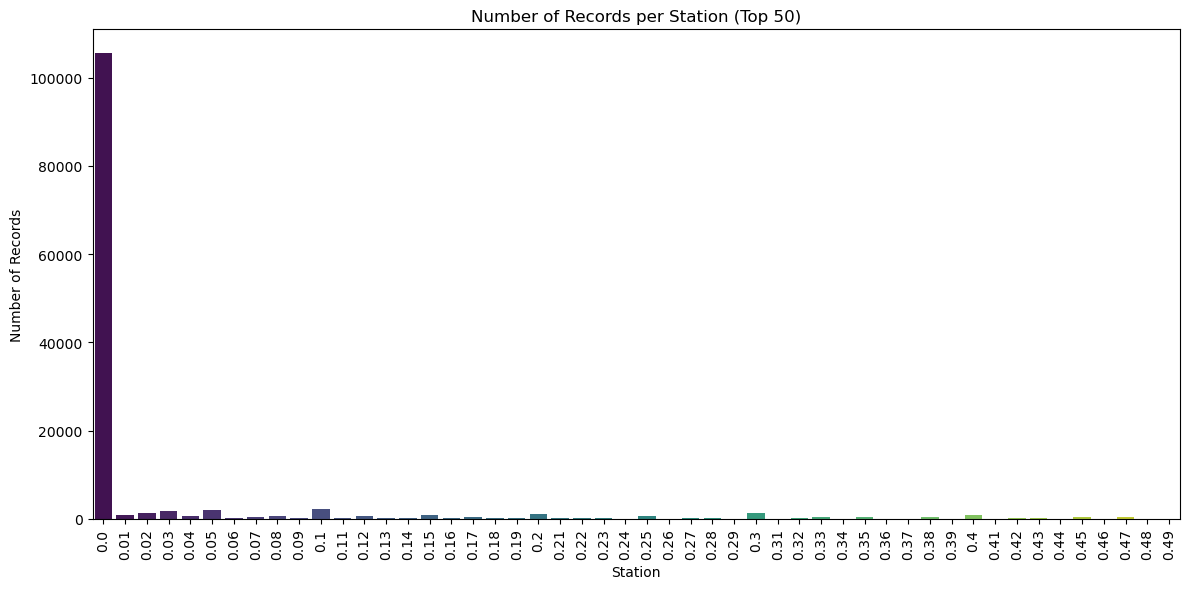

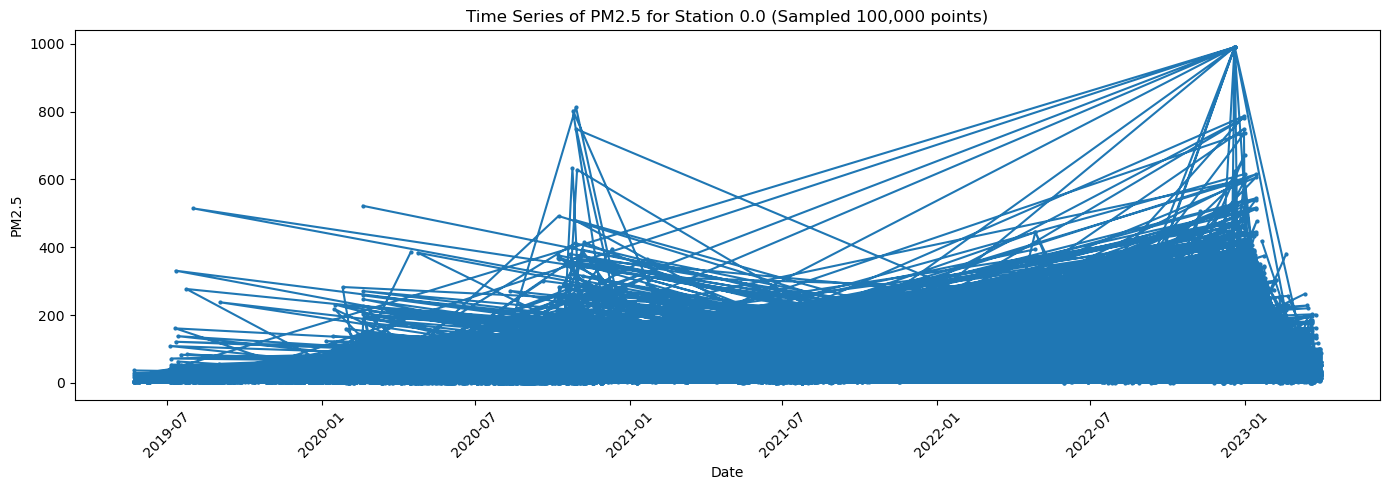

ValueError: could not convert string to float: 'CG007'

<Figure size 1000x800 with 0 Axes>

In [19]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import warnings

# Suppress warnings about format inference.
warnings.filterwarnings("ignore", message="Could not infer format")

# ----------------------------
# 1. Define Expected Columns and Helper Function
# ----------------------------
# Full header from the CSV:
all_columns = [
    "From Date", "To Date", "PM2.5", "PM10", "NO", "NO2", "NOx", "NH3", "SO2", "CO",
    "Ozone", "Benzene", "Toluene", "Eth-Benzene (ug/m3)", "MP-Xylene (ug/m3)",
    "O Xylene (ug/m3)", "RH", "WS (m/s)", "WD (degree)", "SR (W/mt2)", "BP (mmHg)",
    "VWS (m/s)", "RF (mm)", "Temp", "Station", "Xylene (ug/m3)", "Temp (degree C)"
]

# Define columns that are expected to be dates and pure strings.
date_columns = ["From Date", "To Date"]
string_columns = ["Station"]

# All remaining columns are expected to be numeric.
numeric_columns = [col for col in all_columns if col not in (date_columns + string_columns)]

# Optionally, a mapping to standardize alternate column names.
expected_mapping = {
    "From Date": ["From Date"],
    "To Date": ["To Date"],
    "PM2.5": ["PM2.5", "PM2.5 (ug/m3)"],
    "PM10": ["PM10", "PM10 (ug/m3)"],
    "NO": ["NO", "NO (ug/m3)"],
    "NO2": ["NO2", "NO2 (ug/m3)"],
    "NOx": ["NOx", "NOx (ppb)"],
    "NH3": ["NH3", "NH3 (ug/m3)"],
    "SO2": ["SO2", "SO2 (ug/m3)"],
    "CO": ["CO", "CO (mg/m3)"],
    "Ozone": ["Ozone", "Ozone (ug/m3)"],
    "Benzene": ["Benzene", "Benzene (ug/m3)"],
    "Toluene": ["Toluene", "Toluene (ug/m3)"],
    "Temp": ["Temp", "AT (degree C)", "Temp (degree C)"],
    "RH": ["RH", "RH (%)"]
}

def standardize_columns(df):
    """
    Rename DataFrame columns using canonical names defined in expected_mapping.
    """
    for canonical, alternatives in expected_mapping.items():
        for alt in alternatives:
            if alt in df.columns:
                df.rename(columns={alt: canonical}, inplace=True)
                break
    return df

# ----------------------------
# 2. Incremental Merging of Files
# ----------------------------
# 'good_files' should be a list of tuples, e.g.:
#   good_files = [('AP007.csv', 0.0436), ('AP008.csv', 0.0673), ...]
data_dir = "datasets2/datasets"
output_file = "merged_data.csv"

# Remove any existing merged file.
if os.path.exists(output_file):
    os.remove(output_file)

batch_size = 10  # Process files in small batches
for i in range(0, len(good_files), batch_size):
    batch_files = good_files[i : i + batch_size]
    batch_dfs = []
    for f, avg_missing in batch_files:
        # Make sure the file has a .csv extension.
        if not os.path.splitext(f)[1]:
            f = f + ".csv"
        file_path = os.path.join(data_dir, f)
        try:
            # Read each file (optionally parsing "From Date" to help standardize).
            df = pd.read_csv(file_path, parse_dates=["From Date"], low_memory=False)
            df = standardize_columns(df)
            # Create a "Station" column from the filename.
            df["Station"] = os.path.splitext(f)[0]
            batch_dfs.append(df)
        except Exception as e:
            print(f"Error processing {f}: {e}")
    if batch_dfs:
        batch_df = pd.concat(batch_dfs, ignore_index=True)
        # Append batch to merged file; header is written only if file doesn't exist.
        batch_df.to_csv(output_file, mode="a", index=False, header=not os.path.exists(output_file))

print(f"\nMerged data saved incrementally to {output_file}")

# ----------------------------
# 3. Load Merged CSV with Dask Using a Universal Dtype Approach
# ----------------------------
# Force every expected column to be read as a string.
dtype_spec = {col: "object" for col in all_columns}

ddf = dd.read_csv(
    output_file,
    on_bad_lines="skip",
    engine="python",
    blocksize="16MB",
    assume_missing=True,
    dtype=dtype_spec
)

# Convert date columns explicitly.
for col in date_columns:
    ddf[col] = dd.to_datetime(ddf[col], errors="coerce", infer_datetime_format=True)

# Convert numeric columns explicitly.
for col in numeric_columns:
    ddf[col] = dd.to_numeric(ddf[col], errors="coerce")

# Sample 10% of the data for summary statistics.
ddf_sample = ddf.sample(frac=0.1, random_state=42)
describe_stats_sample = ddf_sample.describe().compute()

print("\nSummary statistics on a 10% sample computed using Dask:")
print(describe_stats_sample)

# ----------------------------
# 4. Visualizations Using Pandas
# ----------------------------
# Load the merged CSV with pandas using the Python engine and skip bad lines.
merged_df = pd.read_csv(
    output_file,
    parse_dates=["From Date"],
    engine="python",
    on_bad_lines="skip"
)
print("Merged DataFrame shape:", merged_df.shape)
print("Merged DataFrame columns:", merged_df.columns.tolist())

# Visualization 1: Bar Plot of Record Counts per Station (Top 50).
plt.figure(figsize=(12, 6))
record_counts = merged_df["Station"].value_counts().sort_index()
sns.barplot(x=record_counts.index[:50], y=record_counts.values[:50], palette="viridis")
plt.xlabel("Station")
plt.ylabel("Number of Records")
plt.title("Number of Records per Station (Top 50)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualization 2: Time Series of PM2.5 for the Station with Maximum Records.
station_max = record_counts.idxmax()
df_max = merged_df[merged_df["Station"] == station_max].sample(n=100000, random_state=42)
plt.figure(figsize=(14, 5))
plt.plot(df_max["From Date"], df_max["PM2.5"], marker="o", linestyle="-", markersize=2)
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title(f"Time Series of PM2.5 for Station {station_max} (Sampled 100,000 points)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 3: Correlation Heatmap for Numeric Columns (Sampled 500,000 rows).
subset_df = merged_df[numeric_columns].sample(n=500000, random_state=42)
plt.figure(figsize=(10, 8))
corr = subset_df.corr()  # All non-numeric entries should already be NaN here.
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Heatmap of Pollutants and Environment\n(Sampled 500,000 points)")
plt.tight_layout()
plt.show()

# ----------------------------
# 5. Optional: Impute Missing Values and Process the Imputed Data
# ----------------------------
merged_df_imputed = merged_df.groupby("Station").apply(lambda grp: grp.ffill().bfill()).reset_index(drop=True)
imputed_output_file = "merged_data_imputed.csv"
merged_df_imputed.to_csv(imputed_output_file, index=False)
print(f"\nImputed merged data saved to {imputed_output_file}")

ddf_imputed = dd.read_csv(
    imputed_output_file,
    on_bad_lines="skip",
    engine="python",
    blocksize="16MB",
    assume_missing=True,
    dtype=dtype_spec
)
for col in date_columns:
    ddf_imputed[col] = dd.to_datetime(ddf_imputed[col], errors="coerce", infer_datetime_format=True)
for col in numeric_columns:
    ddf_imputed[col] = dd.to_numeric(ddf_imputed[col], errors="coerce")
ddf_imputed_sample = ddf_imputed.sample(frac=0.1, random_state=42)
describe_stats_imputed = ddf_imputed_sample.describe().compute()

print("\nAfter imputation, summary statistics (from a 10% sample) computed using Dask:")
print(describe_stats_imputed)


Non-numeric values found in 'WD (degree)': ['CG005' 'BR032' 'BR033' 'CG006' 'BR034' 'CG007' 'BR035' 'CG011' 'CG012'
 'CG010']
Non-numeric values found in 'BP (mmHg)': ['MH009' 'MH013' 'MH012' 'MH010' 'MH011' 'MH014' 'MH015' 'MH016' 'MH017'
 'MH022']
Non-numeric values found in 'VWS (m/s)': ['KA033' 'KA031' 'KA036' 'KA035' 'KA039' 'KA038' 'KL005' 'KL004' 'KL003'
 'KL002']
Non-numeric values found in 'RF (mm)': ['KA018' 'KA020' 'KA021' 'KA022' 'KA023' 'KA024' 'KA025' 'KA026' 'KA028'
 'KA032' 'MH029' 'MH032' 'MH035' 'MH036' 'MH037' 'MH039' 'MN001' 'MN002'
 'MH041' 'ML001' 'MP020' 'MP021' 'MP013' 'MP015' 'OR004' 'OR003' 'OR005'
 'OR006' 'OR007' 'OR008']
Non-numeric values found in 'Temp': ['BR010' 'BR009' 'BR015' 'BR016' 'BR017' 'BR021' 'BR022' 'BR020' 'BR018'
 'BR019']


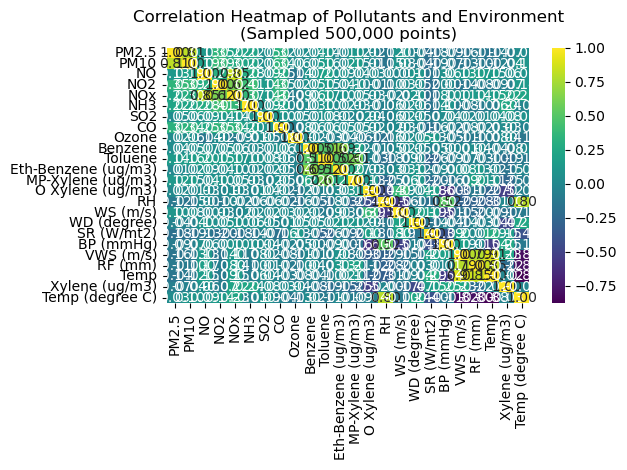

In [21]:
# Identify non-numeric values in each numeric column
for col in numeric_columns:
    bad_values = merged_df[pd.to_numeric(merged_df[col], errors='coerce').isna() & merged_df[col].notna()][col].unique()
    if bad_values.size > 0:
        print(f"Non-numeric values found in '{col}': {bad_values}")

# Convert all numeric columns to floats while replacing non-convertible values with NaN
for col in numeric_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Now try computing correlation again
corr = merged_df[numeric_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Heatmap of Pollutants and Environment\n(Sampled 500,000 points)")
plt.tight_layout()
plt.show()


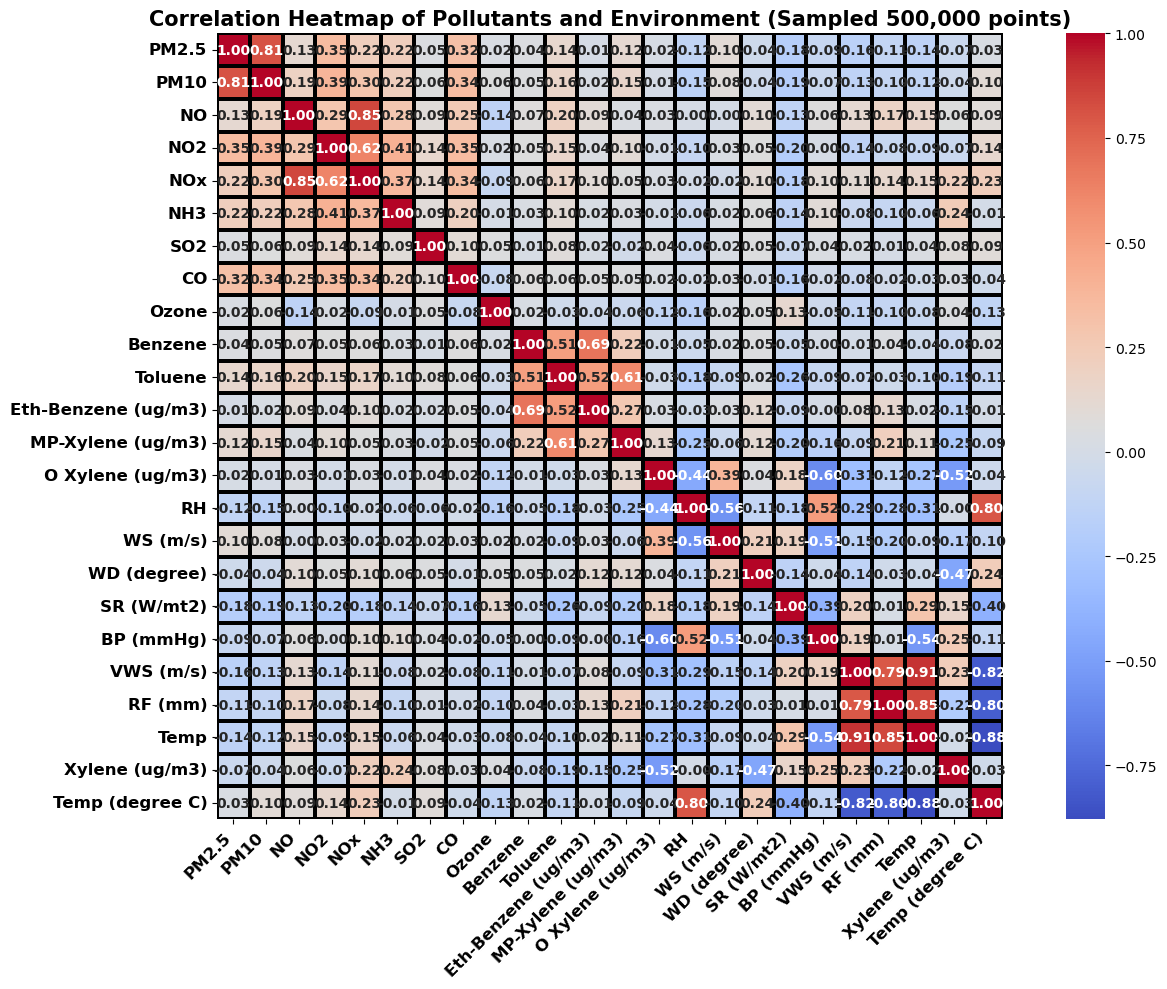

In [27]:
plt.figure(figsize=(14, 10))  # Make the figure larger
corr = merged_df[numeric_columns].corr()  # Compute correlations

sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="coolwarm",  # Use a contrasting color palette
    linewidths=1.5, linecolor="black", square=True, # Add clear gridlines
    annot_kws={"size": 10, "fontweight": "bold"}  # Adjust annotation font size & bold text
)

plt.xticks(rotation=45, ha='right', fontsize=12, fontweight="bold")  # Rotate x-axis labels
plt.yticks(fontsize=12, fontweight="bold")  # Adjust y-axis label font size
plt.title("Correlation Heatmap of Pollutants and Environment (Sampled 500,000 points)", fontsize=15, fontweight="bold")

plt.tight_layout()
plt.show()


In [47]:
# ----------------------------
# 5. Option 2: Explicitly Exclude the Grouping Column for Imputation
# ----------------------------

# Define the output file for imputed data.
imputed_output_file = "merged_data_imputed.csv"

# Save "Station" separately
station_series = merged_df["Station"]

# Drop the "Station" column before imputation
df_to_impute = merged_df.drop(columns=["Station"])

# Group by the station information (using station_series) and apply ffill + bfill
# This groups the rows by the corresponding station from station_series.
imputed_data = df_to_impute.groupby(station_series).apply(lambda grp: grp.ffill().bfill())

# Reset the index so that the grouping key (which is the station) becomes a column again.
# The resulting index from groupby will be named "level_0" by default.
imputed_data = imputed_data.reset_index(level=0).rename(columns={"level_0": "Station"})

# Save the imputed DataFrame to CSV.
imputed_data.to_csv(imputed_output_file, index=False)
print(f"\nImputed merged data saved to {imputed_output_file} (explicitly excluding 'Station' from imputation)")

# Now load the imputed CSV using Dask with the universal dtype specification.
ddf_imputed = dd.read_csv(
    imputed_output_file,
    on_bad_lines="skip",
    engine="python",
    blocksize="16MB",
    assume_missing=True,
    dtype=dtype_spec
)

# Convert date columns to datetime.
for col in date_columns:
    ddf_imputed[col] = dd.to_datetime(ddf_imputed[col], errors="coerce", infer_datetime_format=True)

# Convert numeric columns to proper numeric types.
for col in numeric_columns:
    ddf_imputed[col] = dd.to_numeric(ddf_imputed[col], errors="coerce")

# Sample 10% of the imputed data to compute summary statistics.
ddf_imputed_sample = ddf_imputed.sample(frac=0.1, random_state=42)
describe_stats_imputed = ddf_imputed_sample.describe().compute()

print("\nAfter imputation (explicit exclusion), summary statistics (from a 10% sample) computed using Dask:")
print(describe_stats_imputed)



Imputed merged data saved to merged_data_imputed.csv (explicitly excluding 'Station' from imputation)

After imputation (explicit exclusion), summary statistics (from a 10% sample) computed using Dask:
                 From Date              To Date        PM2.5          PM10  \
count                 9660                95244  9660.000000  95236.000000   
min    2019-05-24 10:00:00  2017-07-01 04:00:00     0.020000      0.010000   
25%    2020-09-22 16:45:00  2021-08-28 19:00:00    15.357500     29.000000   
50%    2021-08-28 18:00:00  2022-05-19 18:00:00    23.050000     53.637500   
75%    2022-09-13 02:00:00  2022-12-26 10:45:00    34.950000    131.250000   
max    2023-03-31 21:00:00  2023-03-31 23:00:00   990.000000    999.990000   
mean                   NaN                  NaN    31.851322     59.270705   
std                    NaN                  NaN    39.012637     63.826543   

                 NO           NO2           NOx           NH3           SO2  \
count  95238.00

In [13]:
import pandas as pd
import os

# Specify the path to your merged CSV file
file_path = "merged_data.csv"

# --- File Size ---
filesize_bytes = os.path.getsize(file_path)
filesize_mb = filesize_bytes / (1024 * 1024)
print(f"File size: {filesize_mb:.2f} MB")

# --- Sample DataFrame Information ---
# Read the first 1000 rows to inspect columns, dtypes, and memory usage
sample_df = pd.read_csv(file_path, nrows=1000)
print("\n--- Sample DataFrame Information ---")
print("Columns:")
print(sample_df.columns.tolist())
print("\nData Types:")
print(sample_df.dtypes)
print("\nMemory Usage Per Column:")
print(sample_df.memory_usage(deep=True))

# --- Detailed Header and Row Column Count Check ---
with open(file_path, 'r', encoding='utf-8') as f:
    # Get header
    header_line = f.readline()
    header = header_line.strip().split(',')
    header_count = len(header)
    print(f"\nHeader has {header_count} columns:")
    print(header)
    
    # Inspect the first few lines for column count mismatches
    mismatch_count = 0
    total_lines = 0
    # We'll check, for instance, the next 5000 lines
    for i, line in enumerate(f):
        total_lines += 1
        cols = line.strip().split(',')
        if len(cols) != header_count:
            # Print mismatches for the first 10 occurrences to avoid flooding output
            if mismatch_count < 10:
                print(f"Mismatch in line {i + 2}: expected {header_count} columns, got {len(cols)}")
            mismatch_count += 1
        if total_lines >= 5000:
            break
    print(f"\nChecked {total_lines} data lines.")
    print(f"Number of lines with mismatched columns (in first 5000 lines): {mismatch_count}")


File size: 1535.56 MB

--- Sample DataFrame Information ---
Columns:
['From Date', 'To Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'RH', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'RF (mm)', 'Temp', 'Station', 'Xylene (ug/m3)', 'Temp (degree C)']

Data Types:
From Date               object
To Date                 object
PM2.5                  float64
PM10                   float64
NO                     float64
NO2                    float64
NOx                    float64
NH3                    float64
SO2                    float64
CO                     float64
Ozone                  float64
Benzene                float64
Toluene                float64
Eth-Benzene (ug/m3)    float64
MP-Xylene (ug/m3)      float64
O Xylene (ug/m3)       float64
RH                     float64
WS (m/s)               float64
WD (degree)            float64
SR (W/mt2)  

In [15]:
import pandas as pd
import os

# Path to your merged CSV file
file_path = "merged_data.csv"

# Read a sample of, say, 10,000 rows from the file.
sample_df = pd.read_csv(file_path, nrows=10000)

# Define a list of columns that are expected to be numeric.
# You can adjust this list based on your knowledge of the dataset.
expected_numeric_columns = [
    "PM2.5", "PM10", "NO", "NO2", "NOx", "NH3", "SO2", 
    "CO", "Ozone", "Benzene", "Toluene", "Temp", "RH",
    "WS (m/s)", "RF (mm)", "BP (mmHg)", "VWS (m/s)"
]

print("=== Inspecting Expected-Numeric Columns ===\n")

for col in expected_numeric_columns:
    if col in sample_df.columns:
        # Show the dtype as read by pandas
        print(f"Column '{col}': initially dtype = {sample_df[col].dtype}")
        
        # Try converting the column using pd.to_numeric
        conv = pd.to_numeric(sample_df[col], errors='coerce')
        # Identify rows that fail to convert while original value is not missing
        bad_values = sample_df.loc[conv.isna() & sample_df[col].notna(), col].unique()
        if len(bad_values) > 0:
            print(f"  Problematic non-numeric values in '{col}': {bad_values}")
        else:
            print(f"  All values converted successfully (or were already numeric).")
    else:
        print(f"Column '{col}' not found in the sample data.")
    print("\n")

# Optionally, if you want to examine problematic rows for a specific column (e.g., "WS (m/s)"),
# you can iterate through the file in chunks:
print("=== Detailed Check for 'WS (m/s)' Column via Chunks ===")
bad_values_ws = []
chunksize = 100000
for chunk in pd.read_csv(file_path, usecols=["WS (m/s)"], chunksize=chunksize):
    conv_chunk = pd.to_numeric(chunk["WS (m/s)"], errors='coerce')
    # Find values that did not convert
    bad_in_chunk = chunk.loc[conv_chunk.isna() & chunk["WS (m/s)"].notna(), "WS (m/s)"].unique()
    if len(bad_in_chunk) > 0:
        bad_values_ws.extend(bad_in_chunk)
        
if bad_values_ws:
    # Get unique values from the collected list
    unique_bad_ws = pd.unique(bad_values_ws)
    print(f"Found problematic values in 'WS (m/s)' across chunks: {unique_bad_ws}")
else:
    print("No problematic values found in 'WS (m/s)' column across the sampled chunks.")


=== Inspecting Expected-Numeric Columns ===

Column 'PM2.5': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 'PM10': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 'NO': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 'NO2': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 'NOx': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 'NH3': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 'SO2': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 'CO': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 'Ozone': initially dtype = float64
  All values converted successfully (or were already numeric).


Column 

In [16]:
import pandas as pd

# Path to your merged CSV file
file_path = "merged_data.csv"

# Read a sample of, say, 10,000 rows
sample_df = pd.read_csv(file_path, nrows=10000)

# Define a list of columns that are expected to be numeric.
expected_numeric_columns = ["PM2.5", "PM10", "NO", "NO2", "NOx", "NH3", 
                            "SO2", "CO", "Ozone", "Benzene", "Toluene", 
                            "Temp", "RH", "WS (m/s)", "RF (mm)", "BP (mmHg)",
                            "VWS (m/s)", "SR (W/mt2)", "WD (degree)"]

print("=== Checking Expected Numeric Columns ===\n")
for col in expected_numeric_columns:
    if col in sample_df.columns:
        print(f"Column '{col}' (dtype: {sample_df[col].dtype}):")
        # Use pd.to_numeric to try converting entries to a number; non-convertible become NaN.
        numeric_values = pd.to_numeric(sample_df[col], errors='coerce')
        # Identify rows where the conversion produced NaN but the original value was not NaN.
        problematic = sample_df.loc[numeric_values.isna() & sample_df[col].notna(), col].unique()
        if len(problematic) == 0:
            print("  All values are numeric or convertible.\n")
        else:
            print(f"  Problematic values (non-convertible to numeric): {problematic}\n")
    else:
        print(f"Column '{col}' not found in the sample data.\n")


=== Checking Expected Numeric Columns ===

Column 'PM2.5' (dtype: float64):
  All values are numeric or convertible.

Column 'PM10' (dtype: float64):
  All values are numeric or convertible.

Column 'NO' (dtype: float64):
  All values are numeric or convertible.

Column 'NO2' (dtype: float64):
  All values are numeric or convertible.

Column 'NOx' (dtype: float64):
  All values are numeric or convertible.

Column 'NH3' (dtype: float64):
  All values are numeric or convertible.

Column 'SO2' (dtype: float64):
  All values are numeric or convertible.

Column 'CO' (dtype: float64):
  All values are numeric or convertible.

Column 'Ozone' (dtype: float64):
  All values are numeric or convertible.

Column 'Benzene' (dtype: float64):
  All values are numeric or convertible.

Column 'Toluene' (dtype: float64):
  All values are numeric or convertible.

Column 'Temp' (dtype: float64):
  All values are numeric or convertible.

Column 'RH' (dtype: float64):
  All values are numeric or convertible

Valid stations: ['AP003' 'AP006' 'AP007' 'AP008' 'AP009' 'AP010' 'AS002' 'AS003' 'AS005'
 'AS006' 'BR023' 'BR024' 'BR025' 'BR026' 'BR027' 'BR028' 'BR029' 'BR030'
 'BR031' 'CG004' 'MH018' 'MH019' 'MH020' 'MH021' 'MH023' 'MH024' 'MH025'
 'MH026' 'MH033' 'MH034' 'RJ009' 'RJ010' 'RJ021' 'RJ022' 'RJ023' 'RJ024'
 'RJ025' 'RJ026' 'RJ027' 'RJ028' 'RJ029' 'RJ030' 'RJ031' 'RJ032' 'RJ033'
 'RJ034' 'RJ035' 'SK001' 'TG007' 'TG008' 'UP031' 'UP033' 'UP034' 'UP035'
 'UP036' 'UP037' 'UP038' 'UP039' 'UP040' 'UP041']
Selected Station for analysis: AP003


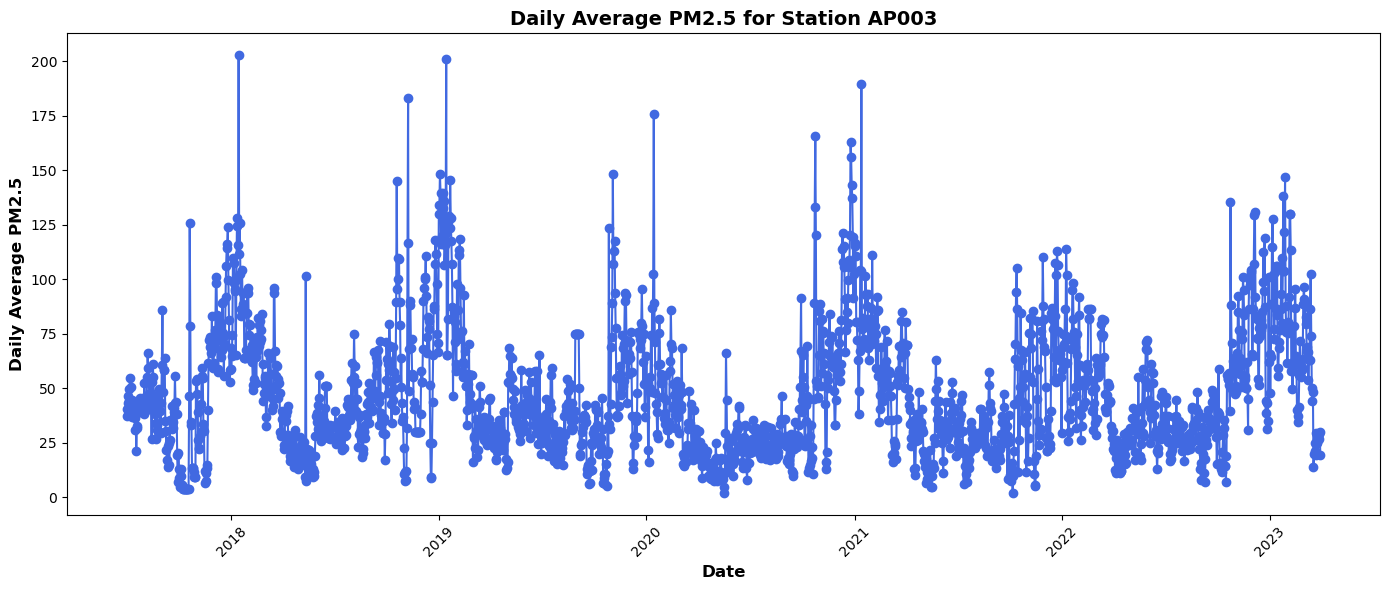

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the imputed data explicitly forcing "Station" as a string and parsing dates.
imputed_df = pd.read_csv(
    "merged_data_imputed.csv",
    parse_dates=["From Date", "To Date"],
    low_memory=False,
    dtype={"Station": str}
)
imputed_df["Station"] = imputed_df["Station"].astype(str)

# Filter out rows where the "Station" column is purely numeric.
# This regex keeps rows that contain at least one letter.
valid_stations_df = imputed_df[imputed_df["Station"].str.contains("[A-Za-z]", na=False)]
print("Valid stations:", valid_stations_df["Station"].unique())

# Now, from the valid stations, determine the station with the most records.
station_counts = valid_stations_df["Station"].value_counts()
selected_station = station_counts.idxmax()
print("Selected Station for analysis:", selected_station)

# Filter and sort the DataFrame for the selected valid station.
station_df = valid_stations_df[valid_stations_df["Station"] == selected_station].copy()
station_df.sort_values("From Date", inplace=True)

# Set "From Date" as the index for time-series operations.
station_df.set_index("From Date", inplace=True)

# Resample the data by day and compute the daily average PM2.5.
daily_avg_pm25 = station_df["PM2.5"].resample("D").mean()

# Plot the daily average PM2.5 over time.
plt.figure(figsize=(14, 6))
plt.plot(daily_avg_pm25.index, daily_avg_pm25.values, marker="o", linestyle="-", color="royalblue")
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Daily Average PM2.5", fontsize=12, fontweight="bold")
plt.title(f"Daily Average PM2.5 for Station {selected_station}", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


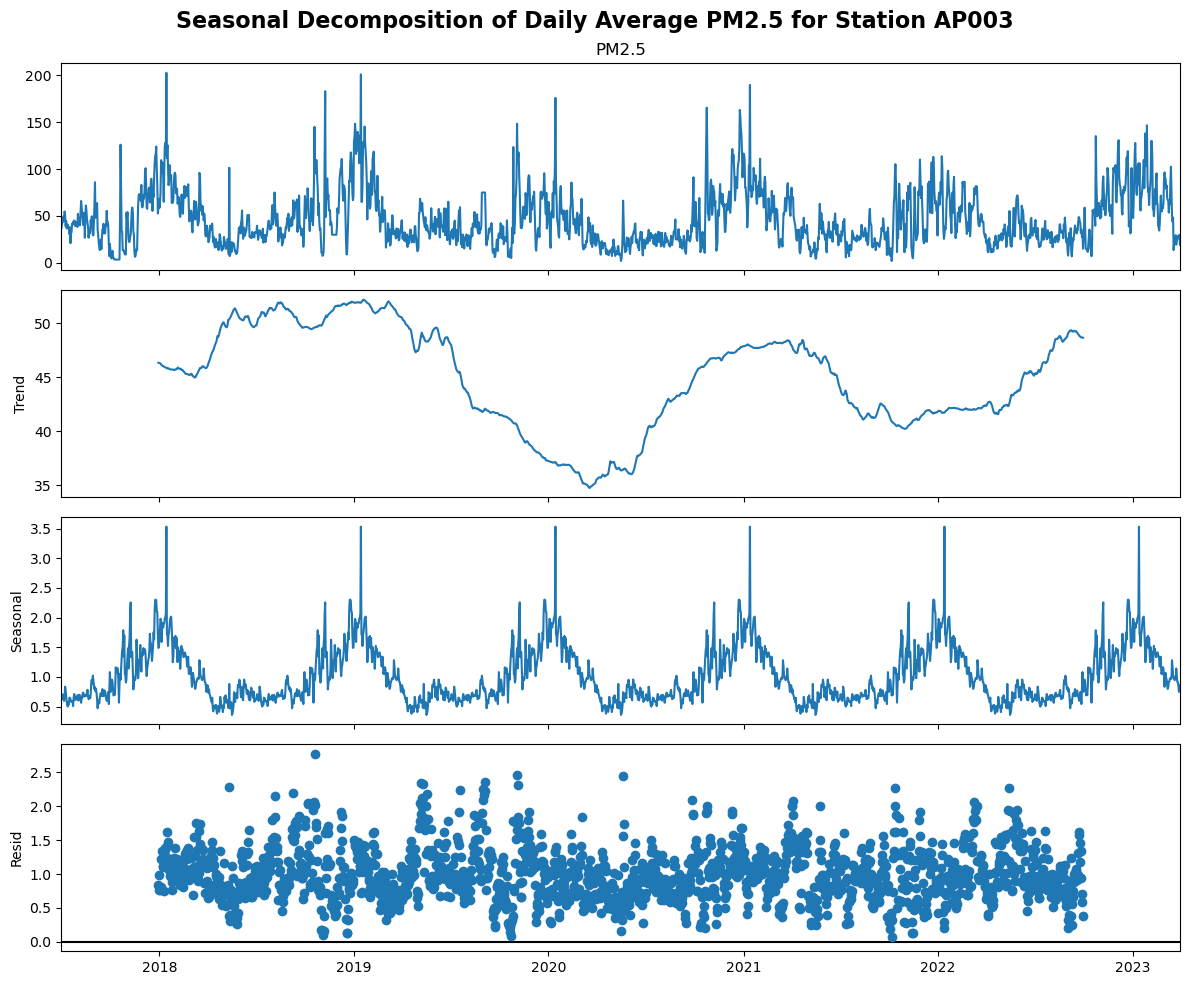

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Ensure we've loaded and preprocessed the imputed data as in previous steps ---
# (This code assumes you already have station_df with "From Date" as the index and daily_avg_pm25 computed)

# If you still have daily_avg_pm25 from previous code, use it directly.
# Otherwise, load the imputed data and perform similar steps:
imputed_df = pd.read_csv(
    "merged_data_imputed.csv",
    parse_dates=["From Date", "To Date"],
    low_memory=False,
    dtype={"Station": str}
)
imputed_df["Station"] = imputed_df["Station"].astype(str)

# Filter out valid stations (only those containing letters)
valid_stations_df = imputed_df[imputed_df["Station"].str.contains("[A-Za-z]", na=False)]
selected_station = "AP003"  # you have already chosen AP003

station_df = valid_stations_df[valid_stations_df["Station"] == selected_station].copy()
station_df.sort_values("From Date", inplace=True)
station_df.set_index("From Date", inplace=True)

# Resample by day to compute daily average PM2.5
daily_avg_pm25 = station_df["PM2.5"].resample("D").mean()

# --- Optional: Fill missing values in the daily series ---
# Fill any missing days by interpolation
daily_avg_pm25_filled = daily_avg_pm25.interpolate(method="time")

# --- Seasonal Decomposition ---
# Since you have daily data, you may use a period of 365 (days)
decomposition = seasonal_decompose(daily_avg_pm25_filled, model="multiplicative", period=365)

plt.rcParams.update({'figure.figsize': (12, 10)})
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Daily Average PM2.5 for Station " + selected_station, fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:54 - cmdstanpy - INFO - Chain [1] done processing


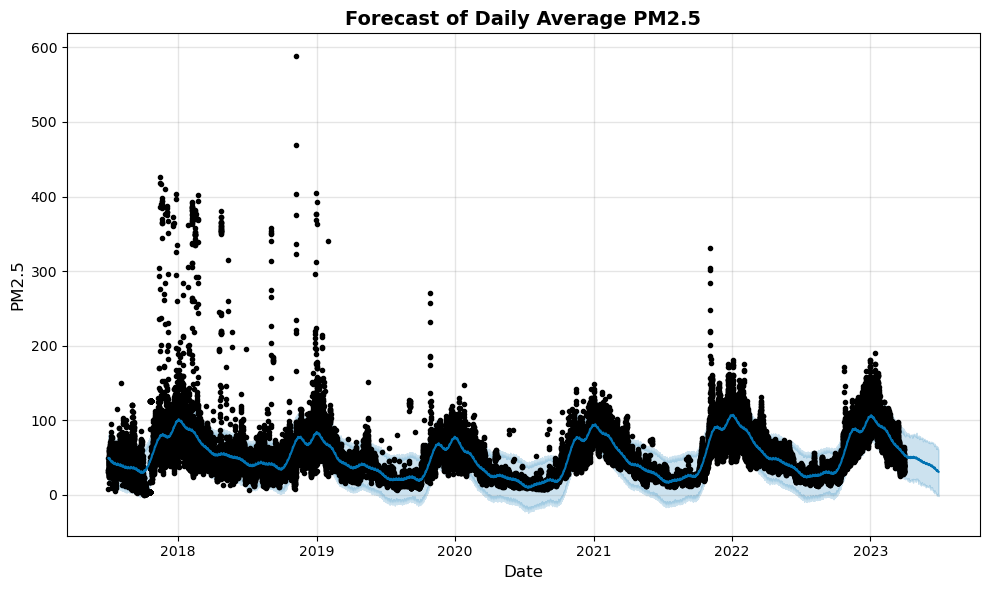

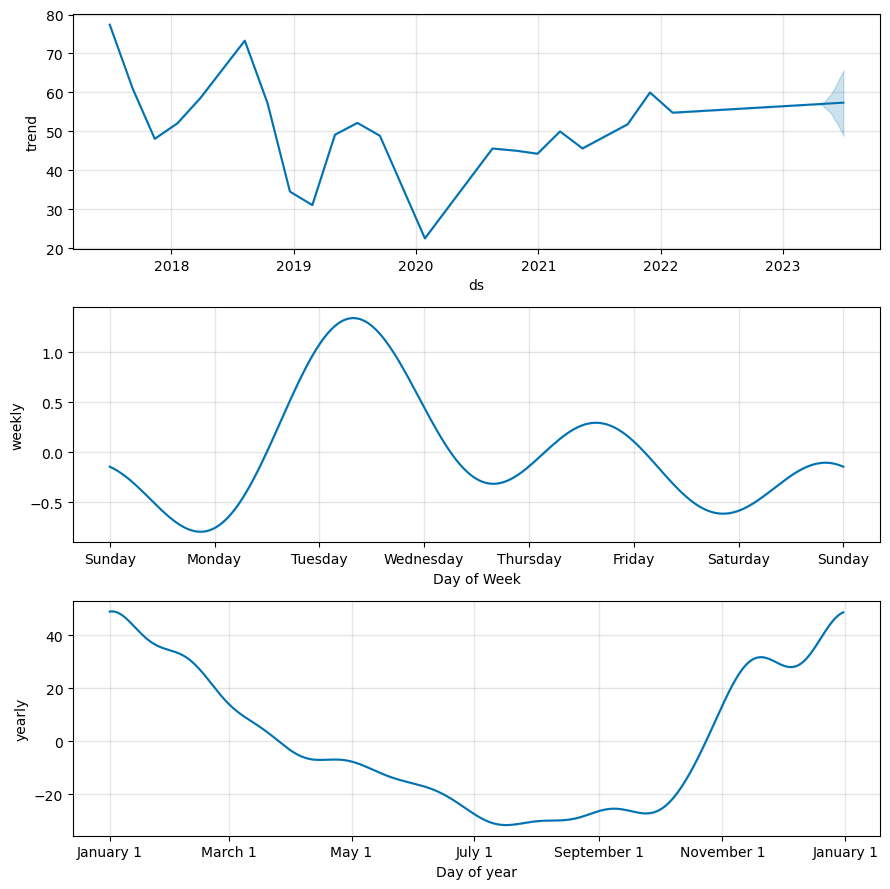

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet   # For older versions: from fbprophet import Prophet

# -------------------------------------------------------
# 1. Load the Imputed Data and Ensure Correct Types
# -------------------------------------------------------
imputed_df = pd.read_csv(
    "merged_data_imputed.csv",
    parse_dates=["From Date", "To Date"],
    low_memory=False,
    dtype={"Station": str}
)
# Ensure "Station" column is string
imputed_df["Station"] = imputed_df["Station"].astype(str)

# -------------------------------------------------------
# 2. Aggregate Daily Data Using Only Numeric Columns
# -------------------------------------------------------
# Define which columns are numeric (exclude non-numeric ones)
# In our dataset, we consider "From Date", "To Date", and "Station" non-numeric.
numeric_columns = [col for col in imputed_df.columns if col not in ["From Date", "To Date", "Station"]]

# Compute daily averages by grouping on "From Date" and taking the mean of the numeric columns.
daily_avg = imputed_df.groupby("From Date")[numeric_columns].mean().reset_index()

# -------------------------------------------------------
# 3. Prepare Data for Forecasting with Prophet
# -------------------------------------------------------
# Select the pollutant to forecast. You can change this variable as needed.
pollutant = "PM2.5"

# Create a DataFrame with columns "ds" (for timestamp) and "y" (for target variable)
forecast_df = daily_avg[["From Date", pollutant]].rename(columns={"From Date": "ds", pollutant: "y"})

# Fill any missing values in the target time series using linear interpolation.
forecast_df["y"] = forecast_df["y"].interpolate(method="linear")

# -------------------------------------------------------
# 4. Build and Fit the Prophet Forecasting Model
# -------------------------------------------------------
# Initialize Prophet with yearly and weekly seasonality enabled (you can adjust these settings).
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(forecast_df)

# Forecast the next 90 days (adjust if needed)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# -------------------------------------------------------
# 5. Plot the Forecast and Components
# -------------------------------------------------------
# Plot forecast with historical data.
fig1 = model.plot(forecast)
plt.title(f"Forecast of Daily Average {pollutant}", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel(pollutant, fontsize=12)
plt.tight_layout()
plt.show()

# Plot forecast components (trend, yearly & weekly seasonality, etc.)
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]

21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:23 - cmdstanpy - INFO - Chain [1] done processing
21:47:25 - cmdstanpy - INFO - Chain [1] start processing
21:47:41 - cmdstanpy - INFO - Chain [1] done processing
21:47:43 - cmdstanpy - INFO - Chain [1] start processing
21:48:03 - cmdstanpy - INFO - Chain [1] done processing
21:48:06 - cmdstanpy - INFO - Chain [1] start processing
21:48:28 - cmdstanpy - INFO - Chain [1] done processing
21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:57 - cmdstanpy - INFO - Chain [1] done processing
21:49:01 - cmdstanpy - INFO - Chain [1] start processing
21:49:37 - cmdstanpy - INFO - Chain [1] done processing
21:49:41 - cmdstanpy - INFO - Chain [1] start processing
21:50:18 - cmdstanpy - INFO - Chain [1] done processing
21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing


Performance Metrics:
          horizon       rmse      mape        mae
0 9 days 00:00:00  17.374399  0.298629  12.310250
1 9 days 01:00:00  17.423901  0.299732  12.341828
2 9 days 02:00:00  17.469032  0.301343  12.380487
3 9 days 03:00:00  17.500791  0.303307  12.413247
4 9 days 04:00:00  17.537221  0.305766  12.450469


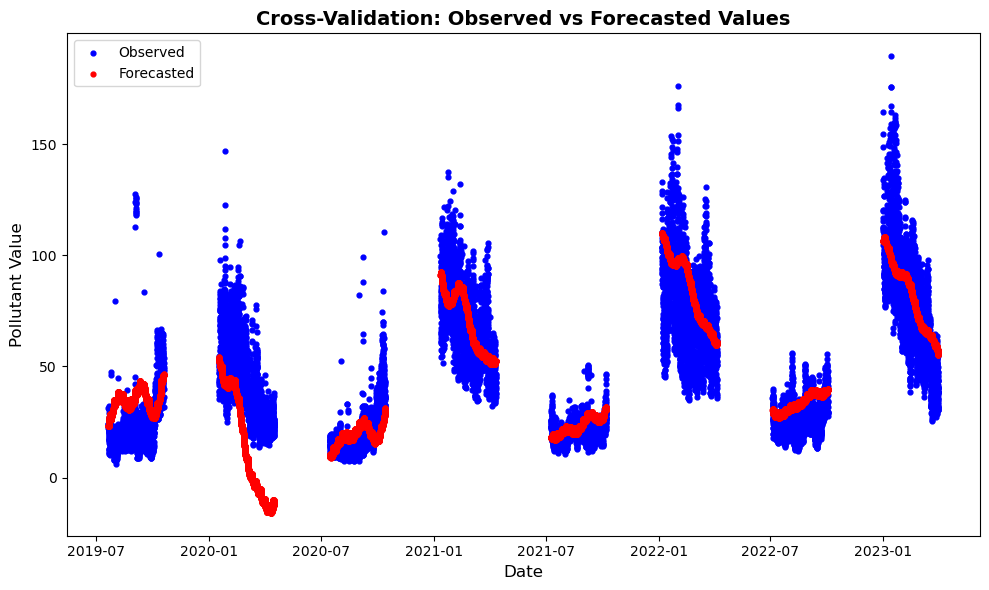

In [61]:
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import pandas as pd

# --- Exact Step: Evaluate the Forecast Performance ---

# Perform cross-validation on the existing Prophet model.
# In this example, we use:
#   - initial = '730 days': use the first two years of data as training,
#   - period = '180 days': make predictions every 180 days,
#   - horizon = '90 days': forecast 90 days into the future each time.
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='90 days')

# Compute performance metrics (e.g., RMSE, MAPE, MAE)
df_p = performance_metrics(df_cv)
print("Performance Metrics:")
print(df_p[['horizon', 'rmse', 'mape', 'mae']].head())

# --- Plot the Cross-Validation Results ---

plt.figure(figsize=(10, 6))
# Plot observed values as blue circles
plt.scatter(df_cv['ds'], df_cv['y'], label='Observed', color='blue', s=12)
# Plot forecasted values as red dots
plt.scatter(df_cv['ds'], df_cv['yhat'], label='Forecasted', color='red', s=12)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Pollutant Value", fontsize=12)
plt.title("Cross-Validation: Observed vs Forecasted Values", fontsize=14, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()


21:58:48 - cmdstanpy - INFO - Chain [1] start processing
21:59:21 - cmdstanpy - INFO - Chain [1] done processing


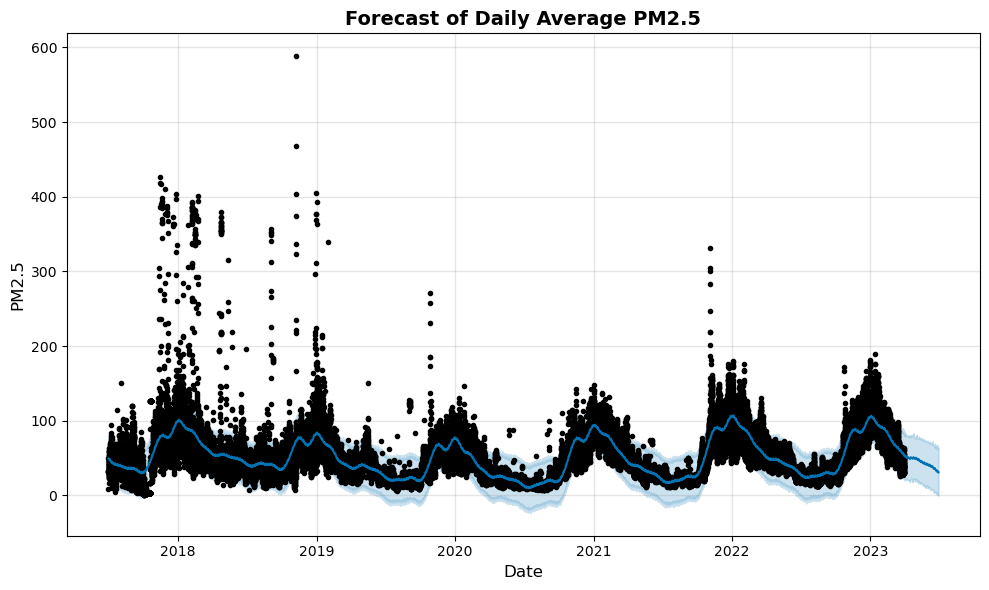

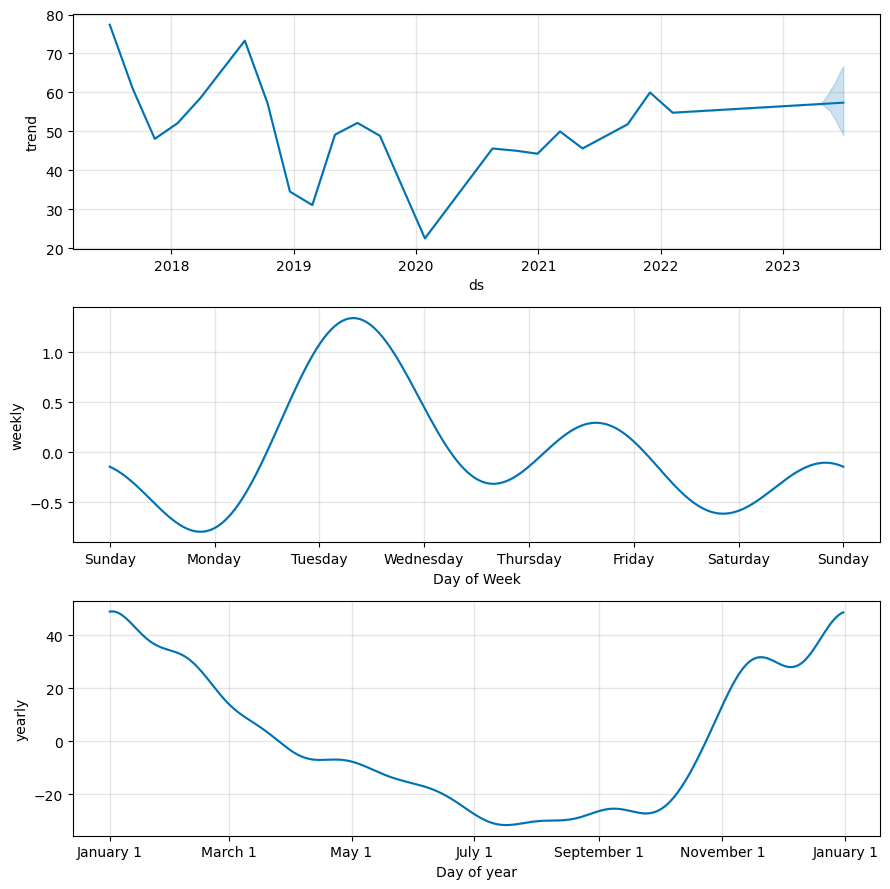

  0%|          | 0/8 [00:00<?, ?it/s]

21:59:39 - cmdstanpy - INFO - Chain [1] start processing
21:59:47 - cmdstanpy - INFO - Chain [1] done processing
21:59:49 - cmdstanpy - INFO - Chain [1] start processing
22:00:05 - cmdstanpy - INFO - Chain [1] done processing
22:00:09 - cmdstanpy - INFO - Chain [1] start processing
22:00:29 - cmdstanpy - INFO - Chain [1] done processing
22:00:32 - cmdstanpy - INFO - Chain [1] start processing
22:00:55 - cmdstanpy - INFO - Chain [1] done processing
22:00:58 - cmdstanpy - INFO - Chain [1] start processing
22:01:23 - cmdstanpy - INFO - Chain [1] done processing
22:01:27 - cmdstanpy - INFO - Chain [1] start processing
22:01:59 - cmdstanpy - INFO - Chain [1] done processing
22:02:03 - cmdstanpy - INFO - Chain [1] start processing
22:02:38 - cmdstanpy - INFO - Chain [1] done processing
22:02:41 - cmdstanpy - INFO - Chain [1] start processing
22:03:19 - cmdstanpy - INFO - Chain [1] done processing


Performance Metrics:
          horizon       rmse      mape        mae
0 9 days 00:00:00  17.374399  0.298629  12.310250
1 9 days 01:00:00  17.423901  0.299732  12.341828
2 9 days 02:00:00  17.469032  0.301343  12.380487
3 9 days 03:00:00  17.500791  0.303307  12.413247
4 9 days 04:00:00  17.537221  0.305766  12.450469


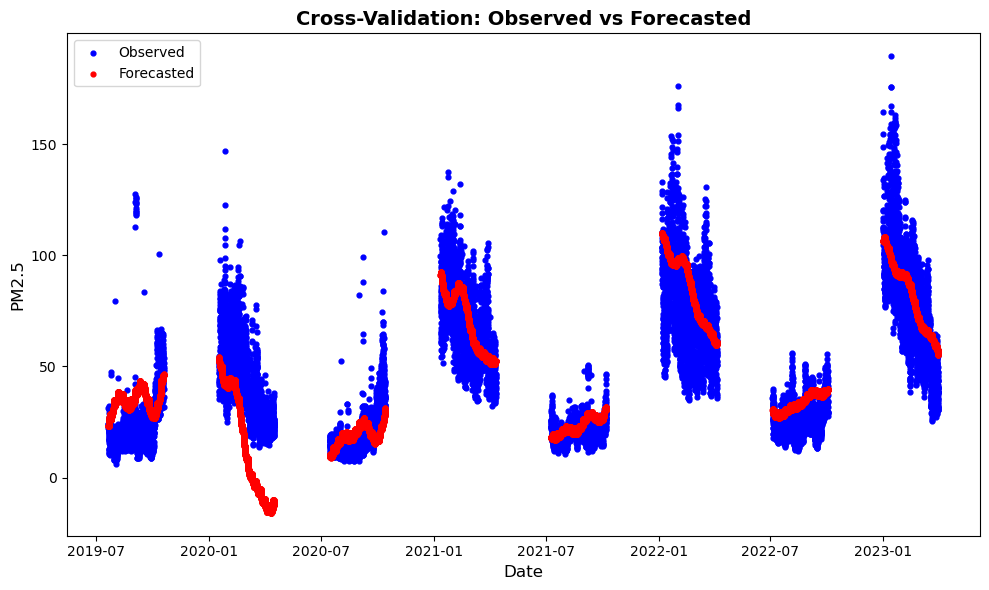

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet  # Use 'from fbprophet import Prophet' with older versions
from prophet.diagnostics import cross_validation, performance_metrics

def forecast_pollutant(pollutant, 
                       data_path="merged_data_imputed.csv",
                       forecast_period=90,
                       cv_initial='730 days',
                       cv_period='180 days',
                       cv_horizon='90 days'):
    """
    Load imputed data, aggregate daily values for the specified pollutant,
    build a Prophet model, forecast future values, and evaluate the model
    via cross-validation.
    
    Parameters:
      pollutant: string, name of the pollutant column to model (e.g., "PM2.5", "NO2")
      data_path: string, path to the imputed CSV
      forecast_period: int, forecast horizon in days
      cv_initial: string, period used for initial training in cross-validation
      cv_period: string, period frequency for cross-validation cutoffs
      cv_horizon: string, forecast horizon for each cross-validation run
      
    Returns:
      model: Trained Prophet model
      forecast: DataFrame containing forecasts
      cv_metrics: DataFrame with cross-validation performance metrics
    """
    # --- Step 1: Load the Imputed Data with Correct Types ---
    df = pd.read_csv(data_path, parse_dates=["From Date", "To Date"],
                     low_memory=False, dtype={"Station": str})
    df["Station"] = df["Station"].astype(str)
    
    # --- Step 2: Aggregate Daily Data for the Given Pollutant ---
    # We group by "From Date" and compute the mean for the given pollutant.
    daily_avg = df.groupby("From Date")[pollutant].mean().reset_index()
    # Rename columns for Prophet (ds: date, y: target variable)
    forecast_df = daily_avg.rename(columns={"From Date": "ds", pollutant: "y"})
    
    # Interpolate to fill any missing values in the target series.
    forecast_df["y"] = forecast_df["y"].interpolate(method="linear")
    
    # --- Step 3: Build and Fit the Prophet Model ---
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(forecast_df)
    
    # --- Step 4: Forecast Future Values ---
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    
    # --- Plot the Forecast and Its Components ---
    fig1 = model.plot(forecast)
    plt.title(f"Forecast of Daily Average {pollutant}", fontsize=14, fontweight="bold")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(pollutant, fontsize=12)
    plt.tight_layout()
    plt.show()
    
    fig2 = model.plot_components(forecast)
    plt.tight_layout()
    plt.show()
    
    # --- Step 5: Cross-Validation and Performance Metrics ---
    df_cv = cross_validation(model, initial=cv_initial, period=cv_period, horizon=cv_horizon)
    cv_metrics = performance_metrics(df_cv)
    print("Performance Metrics:")
    print(cv_metrics[['horizon', 'rmse', 'mape', 'mae']].head())
    
    # Plot cross-validation results: observed vs forecasted values.
    plt.figure(figsize=(10, 6))
    plt.scatter(df_cv['ds'], df_cv['y'], label='Observed', color='blue', s=12)
    plt.scatter(df_cv['ds'], df_cv['yhat'], label='Forecasted', color='red', s=12)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(pollutant, fontsize=12)
    plt.title("Cross-Validation: Observed vs Forecasted", fontsize=14, fontweight="bold")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return model, forecast, cv_metrics

# ----- Example Call for the Pollutant "PM2.5" -----
model_pm25, forecast_pm25, metrics_pm25 = forecast_pollutant("PM2.5")


Processing forecast for: PM2.5


22:11:07 - cmdstanpy - INFO - Chain [1] start processing
22:11:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/8 [00:00<?, ?it/s]

22:11:53 - cmdstanpy - INFO - Chain [1] start processing
22:12:00 - cmdstanpy - INFO - Chain [1] done processing
22:12:02 - cmdstanpy - INFO - Chain [1] start processing
22:12:17 - cmdstanpy - INFO - Chain [1] done processing
22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:39 - cmdstanpy - INFO - Chain [1] done processing
22:12:43 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
22:13:08 - cmdstanpy - INFO - Chain [1] start processing
22:13:34 - cmdstanpy - INFO - Chain [1] done processing
22:13:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:11 - cmdstanpy - INFO - Chain [1] done processing
22:14:15 - cmdstanpy - INFO - Chain [1] start processing
22:14:49 - cmdstanpy - INFO - Chain [1] done processing
22:14:53 - cmdstanpy - INFO - Chain [1] start processing
22:15:32 - cmdstanpy - INFO - Chain [1] done processing



Performance Metrics for PM2.5:
          horizon       rmse      mape        mae
0 9 days 00:00:00  17.374399  0.298629  12.310250
1 9 days 01:00:00  17.423901  0.299732  12.341828
2 9 days 02:00:00  17.469032  0.301343  12.380487
3 9 days 03:00:00  17.500791  0.303307  12.413247
4 9 days 04:00:00  17.537221  0.305766  12.450469


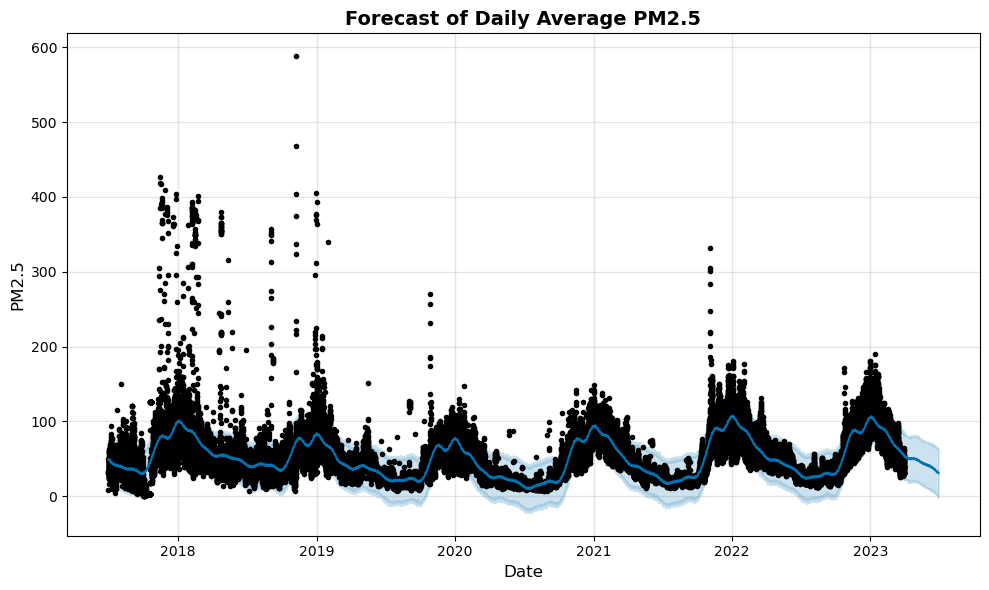

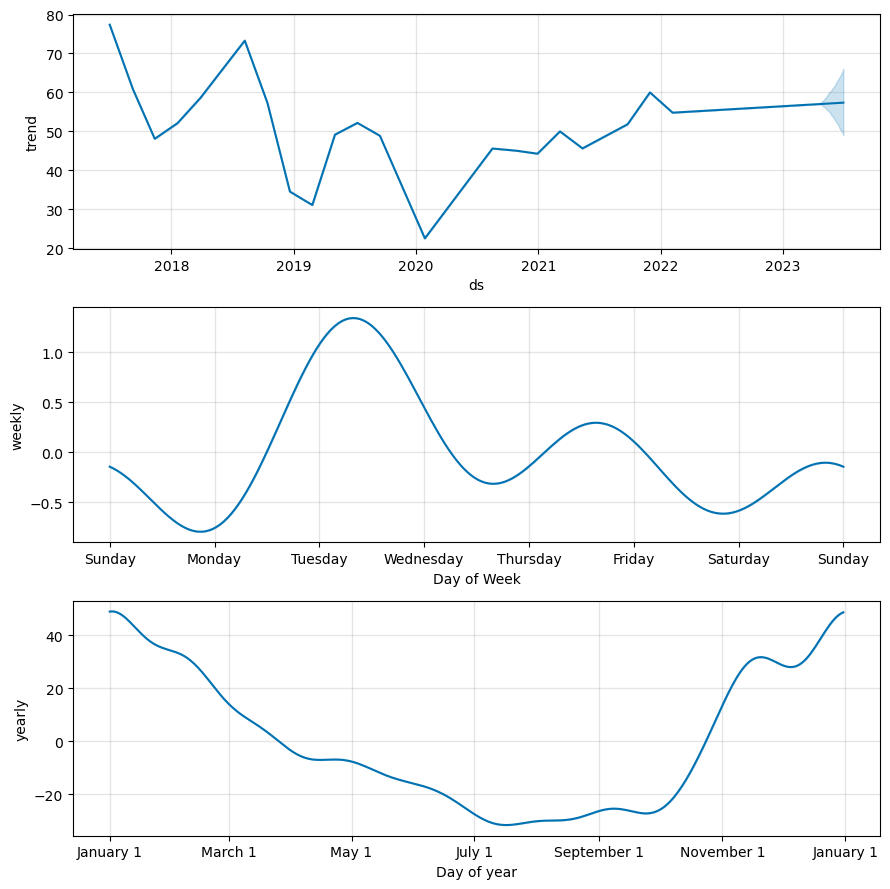

Processing forecast for: NO2


22:15:44 - cmdstanpy - INFO - Chain [1] start processing
22:16:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/8 [00:00<?, ?it/s]

22:16:31 - cmdstanpy - INFO - Chain [1] start processing
22:16:49 - cmdstanpy - INFO - Chain [1] done processing
22:16:51 - cmdstanpy - INFO - Chain [1] start processing
22:17:09 - cmdstanpy - INFO - Chain [1] done processing
22:17:12 - cmdstanpy - INFO - Chain [1] start processing
22:17:39 - cmdstanpy - INFO - Chain [1] done processing
22:17:42 - cmdstanpy - INFO - Chain [1] start processing
22:18:10 - cmdstanpy - INFO - Chain [1] done processing
22:18:13 - cmdstanpy - INFO - Chain [1] start processing
22:19:04 - cmdstanpy - INFO - Chain [1] done processing
22:19:07 - cmdstanpy - INFO - Chain [1] start processing
22:19:47 - cmdstanpy - INFO - Chain [1] done processing
22:19:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:32 - cmdstanpy - INFO - Chain [1] done processing
22:20:35 - cmdstanpy - INFO - Chain [1] start processing
22:21:23 - cmdstanpy - INFO - Chain [1] done processing



Performance Metrics for NO2:
          horizon      rmse      mape       mae
0 9 days 00:00:00  9.179012  0.247941  6.582206
1 9 days 01:00:00  9.207215  0.248564  6.604049
2 9 days 02:00:00  9.231335  0.249183  6.624037
3 9 days 03:00:00  9.248191  0.249716  6.641211
4 9 days 04:00:00  9.257000  0.250032  6.651653


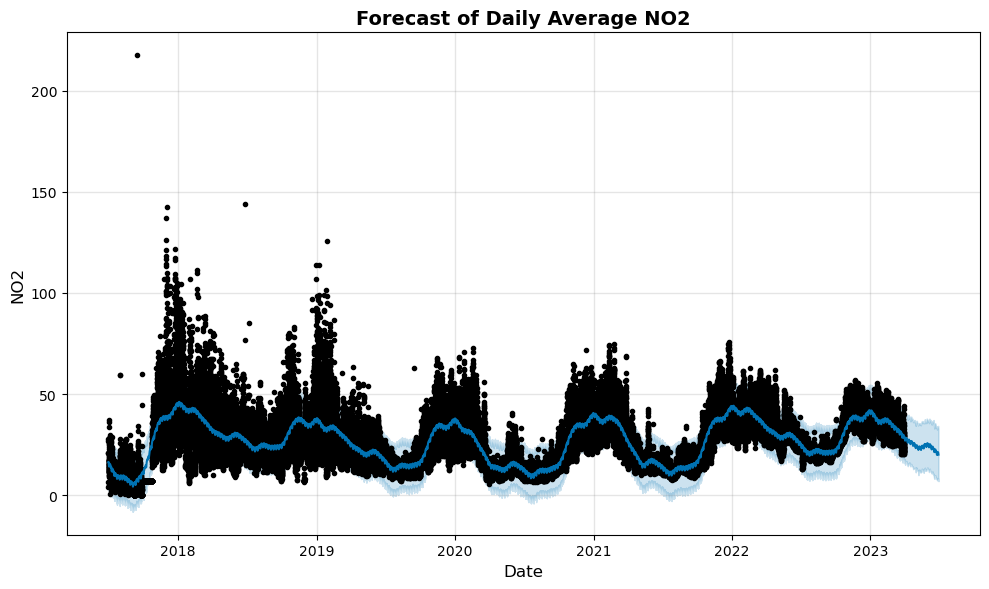

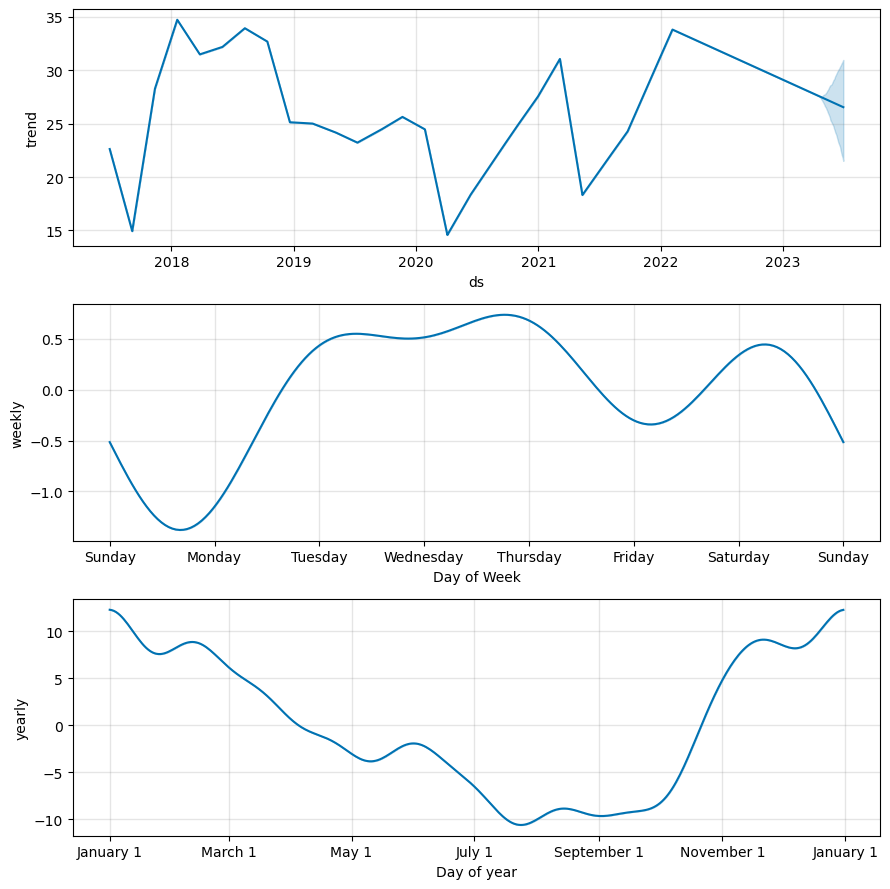

Processing forecast for: PM10


22:21:36 - cmdstanpy - INFO - Chain [1] start processing
22:22:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/8 [00:00<?, ?it/s]

22:22:27 - cmdstanpy - INFO - Chain [1] start processing
22:22:36 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:56 - cmdstanpy - INFO - Chain [1] done processing
22:22:59 - cmdstanpy - INFO - Chain [1] start processing
22:23:27 - cmdstanpy - INFO - Chain [1] done processing
22:23:30 - cmdstanpy - INFO - Chain [1] start processing
22:24:09 - cmdstanpy - INFO - Chain [1] done processing
22:24:13 - cmdstanpy - INFO - Chain [1] start processing
22:24:52 - cmdstanpy - INFO - Chain [1] done processing
22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:25:39 - cmdstanpy - INFO - Chain [1] done processing
22:25:43 - cmdstanpy - INFO - Chain [1] start processing
22:26:20 - cmdstanpy - INFO - Chain [1] done processing
22:26:24 - cmdstanpy - INFO - Chain [1] start processing
22:26:58 - cmdstanpy - INFO - Chain [1] done processing



Performance Metrics for PM10:
          horizon       rmse      mape        mae
0 9 days 00:00:00  35.743550  0.312181  26.329389
1 9 days 01:00:00  35.858115  0.313486  26.423626
2 9 days 02:00:00  35.962388  0.315154  26.517600
3 9 days 03:00:00  36.042798  0.316652  26.599009
4 9 days 04:00:00  36.127980  0.318240  26.683286


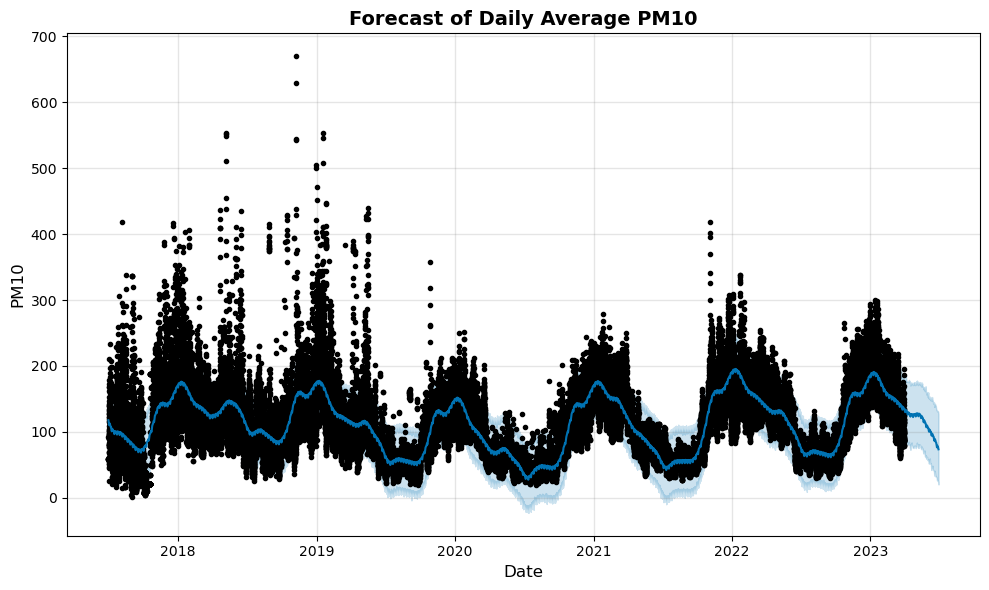

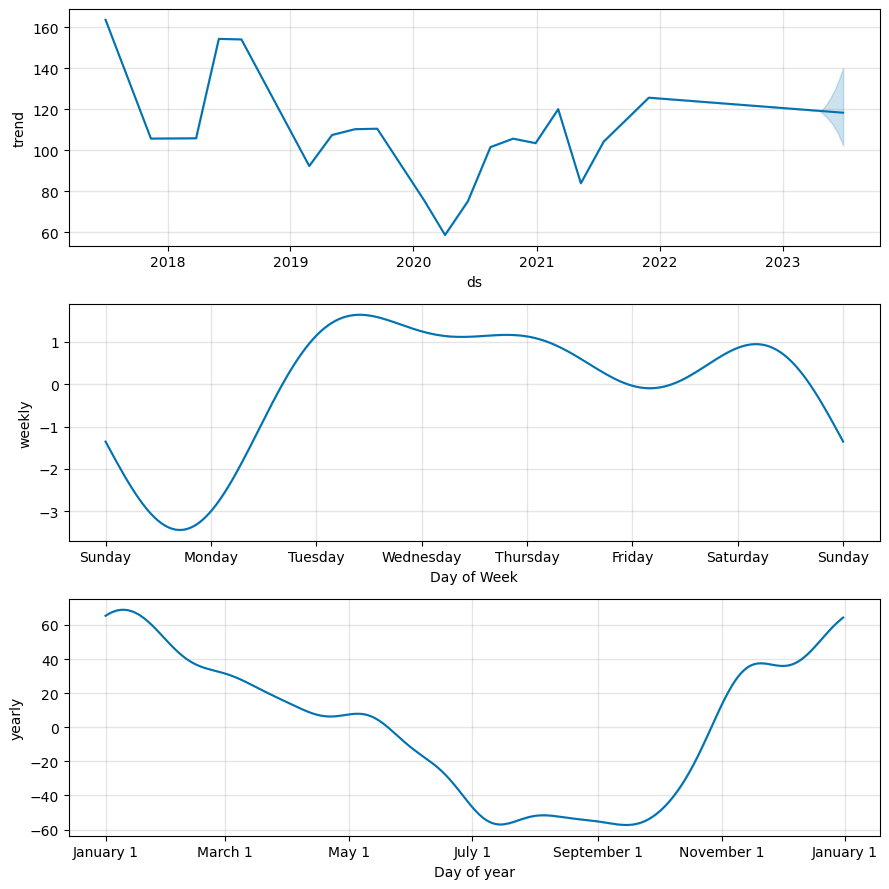

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet  # For older versions use: from fbprophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

def forecast_pollutant(pollutant, df, forecast_period=90, cv_initial='730 days', cv_period='180 days', cv_horizon='90 days'):
    """
    For a given pollutant, aggregate daily data, build a Prophet model, generate forecasts,
    and compute cross-validation performance metrics.
    
    Parameters:
      pollutant: string, the pollutant column name (e.g. "PM2.5", "NO2", "PM10")
      df: DataFrame, the imputed data with at least "From Date" and the pollutant column
      forecast_period: int, number of days to forecast into the future
      cv_initial: string, initial training period for cross-validation
      cv_period: string, spacing between cutoffs in cross-validation
      cv_horizon: string, forecast horizon for each CV run
      
    Returns:
      model: the fitted Prophet model
      forecast: DataFrame, the forecasted values
      cv_metrics: DataFrame, performance metrics from cross-validation
    """
    # Aggregate daily data by taking daily mean of the specified pollutant
    daily_avg = df.groupby("From Date")[pollutant].mean().reset_index()
    # Rename columns to 'ds' and 'y' as required by Prophet
    forecast_df = daily_avg.rename(columns={"From Date": "ds", pollutant: "y"})
    # Ensure continuity of the time series via linear interpolation
    forecast_df["y"] = forecast_df["y"].interpolate(method="linear")
    
    # Build and fit Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(forecast_df)
    
    # Create a future DataFrame and predict
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    
    # Compute cross-validation and performance metrics
    df_cv = cross_validation(model, initial=cv_initial, period=cv_period, horizon=cv_horizon)
    cv_metrics = performance_metrics(df_cv)
    
    return model, forecast, cv_metrics

# -------------------------------
# Main Pipeline: Forecast Multiple Pollutants
# -------------------------------
# Load the imputed data:
imputed_df = pd.read_csv("merged_data_imputed.csv", 
                         parse_dates=["From Date", "To Date"], 
                         low_memory=False, 
                         dtype={"Station": str})
imputed_df["Station"] = imputed_df["Station"].astype(str)

# Define the list of pollutants you want to model. Adjust as needed.
pollutants = ["PM2.5", "NO2", "PM10"]

# Dictionary to store results for each pollutant
results = {}

for pollutant in pollutants:
    try:
        print(f"Processing forecast for: {pollutant}")
        model, forecast, cv_metrics = forecast_pollutant(pollutant, imputed_df)
        results[pollutant] = {'model': model, 'forecast': forecast, 'metrics': cv_metrics}
        
        # Display key performance metrics for this pollutant
        print(f"\nPerformance Metrics for {pollutant}:")
        print(cv_metrics[['horizon', 'rmse', 'mape', 'mae']].head())
        
        # Optionally, plot the forecast and its components
        fig1 = model.plot(forecast)
        plt.title(f"Forecast of Daily Average {pollutant}", fontsize=14, fontweight="bold")
        plt.xlabel("Date", fontsize=12)
        plt.ylabel(pollutant, fontsize=12)
        plt.tight_layout()
        plt.show()
        
        fig2 = model.plot_components(forecast)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Forecasting failed for pollutant {pollutant} due to: {e}")


Comparative Performance Metrics:
  Pollutant  Mean RMSE  Mean MAPE   Mean MAE
0     PM2.5  18.808838   0.441404  14.211544
1       NO2  11.494351   0.338606   8.384771
2      PM10  34.452756   0.331097  26.908678


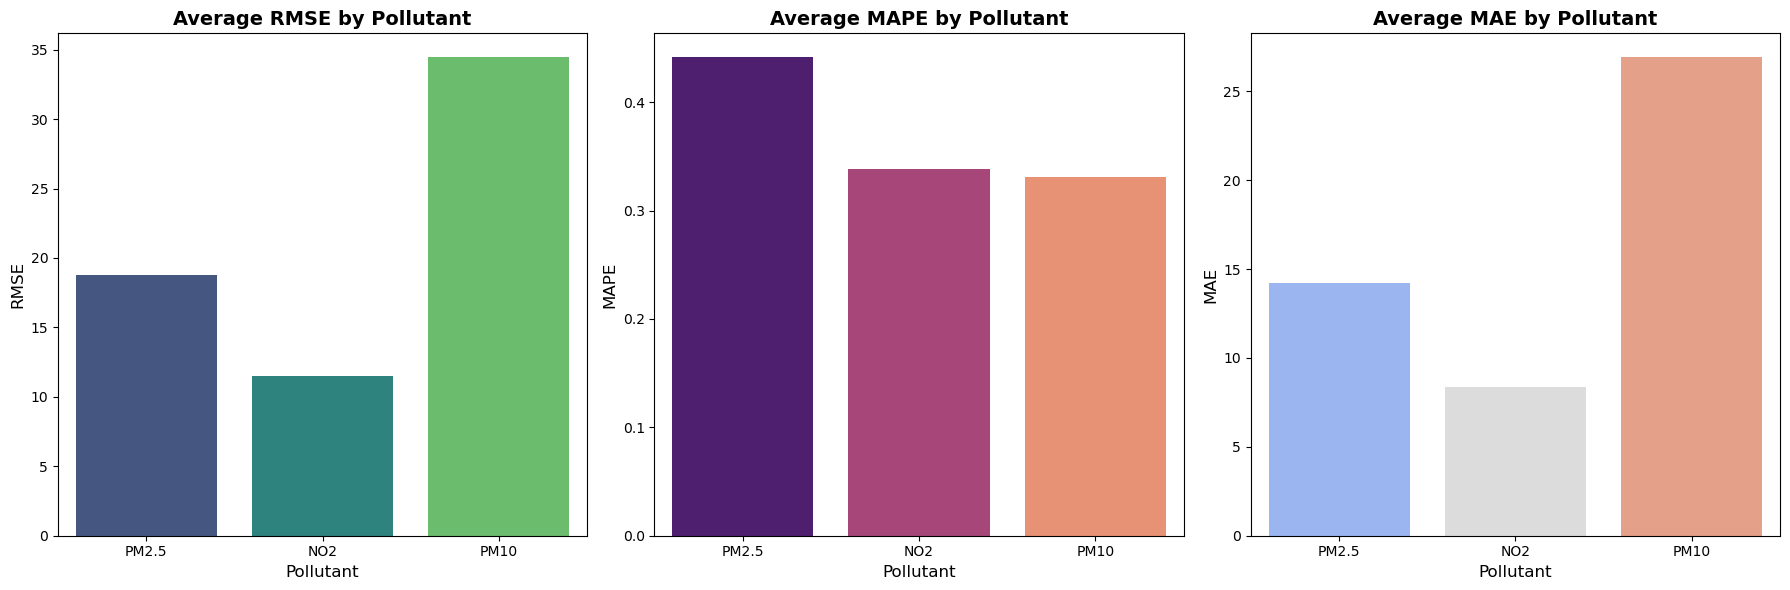

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example summary DataFrame; if you already have summary_df, you can skip this step.
summary_data = {
    "Pollutant": ["PM2.5", "NO2", "PM10"],
    "Mean RMSE": [18.808838, 11.494351, 34.452756],
    "Mean MAPE": [0.441404, 0.338606, 0.331097],
    "Mean MAE": [14.211544, 8.384771, 26.908678]
}
summary_df = pd.DataFrame(summary_data)
print("Comparative Performance Metrics:")
print(summary_df)

# Create the subplots for the bar charts.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot for RMSE
sns.barplot(x='Pollutant', y='Mean RMSE', hue='Pollutant', data=summary_df,
            ax=axes[0], palette="viridis", dodge=False)
axes[0].set_title("Average RMSE by Pollutant", fontsize=14, fontweight="bold")
axes[0].set_ylabel("RMSE", fontsize=12)
axes[0].set_xlabel("Pollutant", fontsize=12)
leg = axes[0].get_legend()
if leg is not None:
    leg.remove()  # Remove the redundant legend if it exists

# Bar plot for MAPE
sns.barplot(x='Pollutant', y='Mean MAPE', hue='Pollutant', data=summary_df,
            ax=axes[1], palette="magma", dodge=False)
axes[1].set_title("Average MAPE by Pollutant", fontsize=14, fontweight="bold")
axes[1].set_ylabel("MAPE", fontsize=12)
axes[1].set_xlabel("Pollutant", fontsize=12)
leg = axes[1].get_legend()
if leg is not None:
    leg.remove()  # Remove legend if it exists

# Bar plot for MAE
sns.barplot(x='Pollutant', y='Mean MAE', hue='Pollutant', data=summary_df,
            ax=axes[2], palette="coolwarm", dodge=False)
axes[2].set_title("Average MAE by Pollutant", fontsize=14, fontweight="bold")
axes[2].set_ylabel("MAE", fontsize=12)
axes[2].set_xlabel("Pollutant", fontsize=12)
leg = axes[2].get_legend()
if leg is not None:
    leg.remove()  # Remove legend if it exists

plt.tight_layout()
plt.show()
